In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
from june import World 
from june.demography.geography import Geography
from june.demography import Demography
from june.interaction import ContactAveraging
from june.infection import Infection
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.logger.read_logger import ReadLogger
from june.infection.infection import InfectionSelector
from june.world import generate_world_from_hdf5, generate_world_from_geography

No --data argument given - defaulting to:
/home/florpi/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/JUNE/configs


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
CONFIG_PATH = "../configs/config_example.yaml"

In [5]:
%%time 

geography = Geography.from_file(
        {
            "super_area": [
                "E02003282",
                "E02001720",
                "E00088544",
                "E02002560",
                "E02002559",
                "E02004314",
            ]
        }
)

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True, include_commute=True)

2020-07-07 15:04:02,000 - june.demography.geography - INFO - There are 129 areas and 5 super_areas in the world.
2020-07-07 15:04:02,007 - june.groups.hospital - INFO - There are 1 hospitals in this geography.
2020-07-07 15:04:02,062 - june.groups.school - INFO - There are 19 schools in this geography.
2020-07-07 15:04:02,086 - june.groups.school - INFO - No school for the age 0 in this world.
2020-07-07 15:04:02,090 - june.groups.school - INFO - No school for the age 1 in this world.
2020-07-07 15:04:02,095 - june.groups.school - INFO - No school for the age 2 in this world.
2020-07-07 15:04:02,338 - june.groups.carehome - INFO - There are 9 care_homes in this geography.
2020-07-07 15:04:07,187 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.
2020-07-07 15:04:10,321 - june.distributors.worker_distributor - INFO - There are 0 who had to be told to stay real
CPU times: user 25.3 s, sys: 817 ms, total: 26.1 s
Wall time: 26.4 s


## Commute, travel and leisure

In [6]:
world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_households(world.households) # this assigns possible social venues to people.

We are also going to need some cemeteries...geography.cemeteries = Cemeteries()


In [7]:
world.cemeteries = Cemeteries()

In [8]:
len(world.people)

46784

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [9]:
world.to_hdf5("world.hdf5")

If we would like to load the world we saved, we just do

In [10]:
world = generate_world_from_hdf5("world.hdf5")

loading population from hdf5 .
loading companies from hdf5 .
loading households from hdf5 .

 34%|███▍      | 15869/46784 [00:00<00:00, 158682.96it/s]


restoring world...


100%|██████████| 46784/46784 [00:00<00:00, 75913.51it/s] 


In [11]:
world.pubs

In [12]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)

you have now a beautiful pre-pandemic world. 

# Adding the infection

Now, you can play around with different models of infections. The building blocks for an infection are: Transmission and Symptoms. For now, only SymptomsConstant and TransmissionConstant are in a state to be used.

In [13]:
selector = InfectionSelector.from_file()

# Adding the interaction

In [14]:
interaction = ContactAveraging.from_file(selector=selector)

Beta are the intensities of the interaction taking place at the different groups

In [15]:
interaction.beta

{'box': 1,
 'pub': 0.1,
 'grocery': 0.1,
 'cinema': 0.1,
 'commute_unit': 1.0,
 'commute_city_unit': 1.0,
 'hospital': 1.0,
 'care_home': 1.0,
 'company': 0.1,
 'school': 0.1,
 'household': 0.2,
 'university': 0.01}

to modify these, simply do

In [16]:
interaction.beta['household'] =0.05
interaction.beta['company'] =0.05
interaction.beta['university'] =0.05
interaction.beta['school'] =0.05
interaction.beta['commute_unit'] =0.1
interaction.beta['commute_city_unit'] =0.1
interaction.beta['hospital'] =0.1

interaction.beta['care_home'] =0.1
interaction.beta['pub'] =0.01
interaction.beta['cinema'] =0.01
interaction.beta['grocery'] =0.01

In [17]:
interaction.beta

{'box': 1,
 'pub': 0.01,
 'grocery': 0.01,
 'cinema': 0.01,
 'commute_unit': 0.1,
 'commute_city_unit': 0.1,
 'hospital': 0.1,
 'care_home': 0.1,
 'company': 0.05,
 'school': 0.05,
 'household': 0.05,
 'university': 0.05}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [18]:
interaction.alpha_physical

2.0

In [19]:
interaction.alpha_physical /= 2

In [20]:
interaction.alpha_physical

1.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [21]:
infection_seed = InfectionSeed(world.super_areas, selector,)

In [22]:
n_cases = 50
infection_seed.unleash_virus(n_cases) # play around with the initial number of cases

# Set policies

In [23]:
policies = Policies.from_file()

# Run the simulation

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [24]:
simulator = Simulator.from_file(
     world, interaction, selector, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    policies = policies
)

In [25]:
%%time
simulator.run()

2020-07-07 15:04:44,918 - june.simulator - INFO - Starting group_dynamics for 250 days at day 0
2020-07-07 15:04:44,919 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 250 days
2020-07-07 15:04:45,998 - june.simulator - INFO - Date = 2020-03-01 04:00:00, number of deaths =  0, number of infected = 50
2020-07-07 15:04:46,645 - june.simulator - INFO - Date = 2020-03-01 08:00:00, number of deaths =  0, number of infected = 50
2020-07-07 15:04:46,986 - june.simulator - INFO - Date = 2020-03-01 12:00:00, number of deaths =  0, number of infected = 50
2020-07-07 15:04:47,492 - june.simulator - INFO - Date = 2020-03-02 00:00:00, number of deaths =  0, number of infected = 50
2020-07-07 15:04:47,888 - june.simulator - INFO - Date = 2020-03-02 01:00:00, number of deaths =  0, number of infected = 50
2020-07-07 15:04:48,211 - june.simulator - INFO - Date = 2020-03-02 05:00:00, number of deaths =  0, number of infected = 50
2020-07-07 15:04:48,522 - june.simulator - INFO - 

2020-07-07 15:05:11,312 - june.simulator - INFO - Date = 2020-03-12 13:00:00, number of deaths =  0, number of infected = 161
2020-07-07 15:05:11,683 - june.simulator - INFO - Date = 2020-03-13 00:00:00, number of deaths =  0, number of infected = 164
2020-07-07 15:05:12,124 - june.simulator - INFO - Date = 2020-03-13 01:00:00, number of deaths =  0, number of infected = 164
2020-07-07 15:05:12,504 - june.simulator - INFO - Date = 2020-03-13 05:00:00, number of deaths =  0, number of infected = 174
2020-07-07 15:05:12,828 - june.simulator - INFO - Date = 2020-03-13 09:00:00, number of deaths =  0, number of infected = 183
2020-07-07 15:05:13,411 - june.simulator - INFO - Date = 2020-03-13 10:00:00, number of deaths =  0, number of infected = 185
2020-07-07 15:05:13,817 - june.simulator - INFO - Date = 2020-03-13 13:00:00, number of deaths =  0, number of infected = 187
2020-07-07 15:05:14,390 - june.simulator - INFO - Date = 2020-03-14 00:00:00, number of deaths =  0, number of infecte

2020-07-07 15:05:54,317 - june.simulator - INFO - Date = 2020-03-25 01:00:00, number of deaths =  0, number of infected = 848
2020-07-07 15:05:55,200 - june.simulator - INFO - Date = 2020-03-25 05:00:00, number of deaths =  0, number of infected = 867
2020-07-07 15:05:56,042 - june.simulator - INFO - Date = 2020-03-25 09:00:00, number of deaths =  0, number of infected = 876
2020-07-07 15:05:56,894 - june.simulator - INFO - Date = 2020-03-25 10:00:00, number of deaths =  0, number of infected = 878
2020-07-07 15:05:57,485 - june.simulator - INFO - Date = 2020-03-25 13:00:00, number of deaths =  0, number of infected = 882
2020-07-07 15:05:58,097 - june.simulator - INFO - Date = 2020-03-26 00:00:00, number of deaths =  0, number of infected = 914
2020-07-07 15:05:59,004 - june.simulator - INFO - Date = 2020-03-26 01:00:00, number of deaths =  0, number of infected = 918
2020-07-07 15:05:59,923 - june.simulator - INFO - Date = 2020-03-26 05:00:00, number of deaths =  0, number of infecte

2020-07-07 15:06:41,047 - june.simulator - INFO - Date = 2020-04-06 05:00:00, number of deaths =  1, number of infected = 1447
2020-07-07 15:06:41,645 - june.simulator - INFO - Date = 2020-04-06 09:00:00, number of deaths =  1, number of infected = 1455
2020-07-07 15:06:42,362 - june.simulator - INFO - Date = 2020-04-06 10:00:00, number of deaths =  1, number of infected = 1455
2020-07-07 15:06:42,996 - june.simulator - INFO - Date = 2020-04-06 13:00:00, number of deaths =  1, number of infected = 1460
2020-07-07 15:06:43,619 - june.simulator - INFO - Date = 2020-04-07 00:00:00, number of deaths =  1, number of infected = 1465
2020-07-07 15:06:44,383 - june.simulator - INFO - Date = 2020-04-07 01:00:00, number of deaths =  1, number of infected = 1466
2020-07-07 15:06:45,098 - june.simulator - INFO - Date = 2020-04-07 05:00:00, number of deaths =  1, number of infected = 1472
2020-07-07 15:06:45,699 - june.simulator - INFO - Date = 2020-04-07 09:00:00, number of deaths =  1, number of 

2020-07-07 15:07:25,330 - june.simulator - INFO - Date = 2020-04-17 13:00:00, number of deaths =  6, number of infected = 1846
2020-07-07 15:07:26,050 - june.simulator - INFO - Date = 2020-04-18 00:00:00, number of deaths =  8, number of infected = 1851
2020-07-07 15:07:26,746 - june.simulator - INFO - Date = 2020-04-18 04:00:00, number of deaths =  8, number of infected = 1854
2020-07-07 15:07:27,440 - june.simulator - INFO - Date = 2020-04-18 08:00:00, number of deaths =  8, number of infected = 1869
2020-07-07 15:07:28,018 - june.simulator - INFO - Date = 2020-04-18 12:00:00, number of deaths =  8, number of infected = 1864
2020-07-07 15:07:28,745 - june.simulator - INFO - Date = 2020-04-19 00:00:00, number of deaths =  8, number of infected = 1876
2020-07-07 15:07:29,465 - june.simulator - INFO - Date = 2020-04-19 04:00:00, number of deaths =  9, number of infected = 1870
2020-07-07 15:07:30,164 - june.simulator - INFO - Date = 2020-04-19 08:00:00, number of deaths =  9, number of 

2020-07-07 15:08:10,415 - june.simulator - INFO - Date = 2020-04-30 00:00:00, number of deaths =  13, number of infected = 2655
2020-07-07 15:08:11,157 - june.simulator - INFO - Date = 2020-04-30 01:00:00, number of deaths =  13, number of infected = 2656
2020-07-07 15:08:11,895 - june.simulator - INFO - Date = 2020-04-30 05:00:00, number of deaths =  13, number of infected = 2689
2020-07-07 15:08:12,507 - june.simulator - INFO - Date = 2020-04-30 09:00:00, number of deaths =  13, number of infected = 2707
2020-07-07 15:08:13,279 - june.simulator - INFO - Date = 2020-04-30 10:00:00, number of deaths =  13, number of infected = 2714
2020-07-07 15:08:13,913 - june.simulator - INFO - Date = 2020-04-30 13:00:00, number of deaths =  13, number of infected = 2717
2020-07-07 15:08:14,602 - june.simulator - INFO - Date = 2020-05-01 00:00:00, number of deaths =  13, number of infected = 2744
2020-07-07 15:08:15,330 - june.simulator - INFO - Date = 2020-05-01 01:00:00, number of deaths =  13, nu

2020-07-07 15:09:04,132 - june.simulator - INFO - Date = 2020-05-12 01:00:00, number of deaths =  17, number of infected = 3549
2020-07-07 15:09:05,253 - june.simulator - INFO - Date = 2020-05-12 05:00:00, number of deaths =  17, number of infected = 3570
2020-07-07 15:09:06,034 - june.simulator - INFO - Date = 2020-05-12 09:00:00, number of deaths =  17, number of infected = 3586
2020-07-07 15:09:07,041 - june.simulator - INFO - Date = 2020-05-12 10:00:00, number of deaths =  17, number of infected = 3586
2020-07-07 15:09:07,721 - june.simulator - INFO - Date = 2020-05-12 13:00:00, number of deaths =  17, number of infected = 3582
2020-07-07 15:09:08,409 - june.simulator - INFO - Date = 2020-05-13 00:00:00, number of deaths =  17, number of infected = 3586
2020-07-07 15:09:09,384 - june.simulator - INFO - Date = 2020-05-13 01:00:00, number of deaths =  17, number of infected = 3582
2020-07-07 15:09:10,303 - june.simulator - INFO - Date = 2020-05-13 05:00:00, number of deaths =  17, nu

2020-07-07 15:09:57,159 - june.simulator - INFO - Date = 2020-05-24 00:00:00, number of deaths =  27, number of infected = 3905
2020-07-07 15:09:57,921 - june.simulator - INFO - Date = 2020-05-24 04:00:00, number of deaths =  27, number of infected = 3907
2020-07-07 15:09:58,692 - june.simulator - INFO - Date = 2020-05-24 08:00:00, number of deaths =  27, number of infected = 3894
2020-07-07 15:09:59,299 - june.simulator - INFO - Date = 2020-05-24 12:00:00, number of deaths =  27, number of infected = 3898
2020-07-07 15:09:59,998 - june.simulator - INFO - Date = 2020-05-25 00:00:00, number of deaths =  27, number of infected = 3881
2020-07-07 15:10:02,306 - june.simulator - INFO - Date = 2020-05-25 01:00:00, number of deaths =  27, number of infected = 3882
2020-07-07 15:10:03,032 - june.simulator - INFO - Date = 2020-05-25 05:00:00, number of deaths =  27, number of infected = 3876
2020-07-07 15:10:03,635 - june.simulator - INFO - Date = 2020-05-25 09:00:00, number of deaths =  27, nu

2020-07-07 15:10:47,559 - june.simulator - INFO - Date = 2020-06-04 13:00:00, number of deaths =  36, number of infected = 3747
2020-07-07 15:10:48,254 - june.simulator - INFO - Date = 2020-06-05 00:00:00, number of deaths =  36, number of infected = 3722
2020-07-07 15:10:49,156 - june.simulator - INFO - Date = 2020-06-05 01:00:00, number of deaths =  36, number of infected = 3723
2020-07-07 15:10:50,079 - june.simulator - INFO - Date = 2020-06-05 05:00:00, number of deaths =  36, number of infected = 3722
2020-07-07 15:10:50,728 - june.simulator - INFO - Date = 2020-06-05 09:00:00, number of deaths =  36, number of infected = 3713
2020-07-07 15:10:51,493 - june.simulator - INFO - Date = 2020-06-05 10:00:00, number of deaths =  36, number of infected = 3707
2020-07-07 15:10:52,102 - june.simulator - INFO - Date = 2020-06-05 13:00:00, number of deaths =  36, number of infected = 3698
2020-07-07 15:10:52,858 - june.simulator - INFO - Date = 2020-06-06 00:00:00, number of deaths =  36, nu

2020-07-07 15:11:37,493 - june.simulator - INFO - Date = 2020-06-17 00:00:00, number of deaths =  40, number of infected = 3052
2020-07-07 15:11:38,272 - june.simulator - INFO - Date = 2020-06-17 01:00:00, number of deaths =  40, number of infected = 3048
2020-07-07 15:11:39,066 - june.simulator - INFO - Date = 2020-06-17 05:00:00, number of deaths =  40, number of infected = 3045
2020-07-07 15:11:39,665 - june.simulator - INFO - Date = 2020-06-17 09:00:00, number of deaths =  40, number of infected = 3036
2020-07-07 15:11:40,457 - june.simulator - INFO - Date = 2020-06-17 10:00:00, number of deaths =  40, number of infected = 3033
2020-07-07 15:11:41,102 - june.simulator - INFO - Date = 2020-06-17 13:00:00, number of deaths =  40, number of infected = 3026
2020-07-07 15:11:41,756 - june.simulator - INFO - Date = 2020-06-18 00:00:00, number of deaths =  40, number of infected = 2988
2020-07-07 15:11:42,543 - june.simulator - INFO - Date = 2020-06-18 01:00:00, number of deaths =  40, nu

2020-07-07 15:12:24,959 - june.simulator - INFO - Date = 2020-06-29 01:00:00, number of deaths =  47, number of infected = 2059
2020-07-07 15:12:25,688 - june.simulator - INFO - Date = 2020-06-29 05:00:00, number of deaths =  47, number of infected = 2056
2020-07-07 15:12:26,304 - june.simulator - INFO - Date = 2020-06-29 09:00:00, number of deaths =  47, number of infected = 2054
2020-07-07 15:12:27,012 - june.simulator - INFO - Date = 2020-06-29 10:00:00, number of deaths =  47, number of infected = 2050
2020-07-07 15:12:27,577 - june.simulator - INFO - Date = 2020-06-29 13:00:00, number of deaths =  47, number of infected = 2049
2020-07-07 15:12:28,200 - june.simulator - INFO - Date = 2020-06-30 00:00:00, number of deaths =  47, number of infected = 2024
2020-07-07 15:12:28,977 - june.simulator - INFO - Date = 2020-06-30 01:00:00, number of deaths =  47, number of infected = 2019
2020-07-07 15:12:29,727 - june.simulator - INFO - Date = 2020-06-30 05:00:00, number of deaths =  47, nu

2020-07-07 15:13:02,499 - june.simulator - INFO - Date = 2020-07-10 10:00:00, number of deaths =  51, number of infected = 1625
2020-07-07 15:13:02,862 - june.simulator - INFO - Date = 2020-07-10 13:00:00, number of deaths =  52, number of infected = 1611
2020-07-07 15:13:03,371 - june.simulator - INFO - Date = 2020-07-11 00:00:00, number of deaths =  53, number of infected = 1595
2020-07-07 15:13:03,948 - june.simulator - INFO - Date = 2020-07-11 04:00:00, number of deaths =  53, number of infected = 1595
2020-07-07 15:13:04,469 - june.simulator - INFO - Date = 2020-07-11 08:00:00, number of deaths =  53, number of infected = 1586
2020-07-07 15:13:04,848 - june.simulator - INFO - Date = 2020-07-11 12:00:00, number of deaths =  53, number of infected = 1597
2020-07-07 15:13:05,382 - june.simulator - INFO - Date = 2020-07-12 00:00:00, number of deaths =  53, number of infected = 1589
2020-07-07 15:13:05,983 - june.simulator - INFO - Date = 2020-07-12 04:00:00, number of deaths =  53, nu

2020-07-07 15:13:36,201 - june.simulator - INFO - Date = 2020-07-22 13:00:00, number of deaths =  59, number of infected = 2726
2020-07-07 15:13:36,619 - june.simulator - INFO - Date = 2020-07-23 00:00:00, number of deaths =  59, number of infected = 2780
2020-07-07 15:13:37,081 - june.simulator - INFO - Date = 2020-07-23 01:00:00, number of deaths =  59, number of infected = 2782
2020-07-07 15:13:37,557 - june.simulator - INFO - Date = 2020-07-23 05:00:00, number of deaths =  59, number of infected = 2844
2020-07-07 15:13:37,942 - june.simulator - INFO - Date = 2020-07-23 09:00:00, number of deaths =  59, number of infected = 2921
2020-07-07 15:13:38,512 - june.simulator - INFO - Date = 2020-07-23 10:00:00, number of deaths =  59, number of infected = 2925
2020-07-07 15:13:38,889 - june.simulator - INFO - Date = 2020-07-23 13:00:00, number of deaths =  59, number of infected = 2945
2020-07-07 15:13:39,290 - june.simulator - INFO - Date = 2020-07-24 00:00:00, number of deaths =  59, nu

2020-07-07 15:14:07,717 - june.simulator - INFO - Date = 2020-08-04 00:00:00, number of deaths =  70, number of infected = 5747
2020-07-07 15:14:08,218 - june.simulator - INFO - Date = 2020-08-04 01:00:00, number of deaths =  70, number of infected = 5761
2020-07-07 15:14:08,762 - june.simulator - INFO - Date = 2020-08-04 05:00:00, number of deaths =  71, number of infected = 5888
2020-07-07 15:14:09,189 - june.simulator - INFO - Date = 2020-08-04 09:00:00, number of deaths =  71, number of infected = 6008
2020-07-07 15:14:09,812 - june.simulator - INFO - Date = 2020-08-04 10:00:00, number of deaths =  71, number of infected = 6016
2020-07-07 15:14:10,228 - june.simulator - INFO - Date = 2020-08-04 13:00:00, number of deaths =  71, number of infected = 6048
2020-07-07 15:14:10,676 - june.simulator - INFO - Date = 2020-08-05 00:00:00, number of deaths =  71, number of infected = 6134
2020-07-07 15:14:11,205 - june.simulator - INFO - Date = 2020-08-05 01:00:00, number of deaths =  71, nu

2020-07-07 15:14:41,755 - june.simulator - INFO - Date = 2020-08-15 12:00:00, number of deaths =  97, number of infected = 9120
2020-07-07 15:14:42,300 - june.simulator - INFO - Date = 2020-08-16 00:00:00, number of deaths =  100, number of infected = 9114
2020-07-07 15:14:44,455 - june.simulator - INFO - Date = 2020-08-16 04:00:00, number of deaths =  101, number of infected = 9134
2020-07-07 15:14:45,155 - june.simulator - INFO - Date = 2020-08-16 08:00:00, number of deaths =  101, number of infected = 9152
2020-07-07 15:14:45,546 - june.simulator - INFO - Date = 2020-08-16 12:00:00, number of deaths =  102, number of infected = 9159
2020-07-07 15:14:46,092 - june.simulator - INFO - Date = 2020-08-17 00:00:00, number of deaths =  103, number of infected = 9165
2020-07-07 15:14:46,822 - june.simulator - INFO - Date = 2020-08-17 01:00:00, number of deaths =  103, number of infected = 9170
2020-07-07 15:14:47,734 - june.simulator - INFO - Date = 2020-08-17 05:00:00, number of deaths =  

2020-07-07 15:15:15,649 - june.simulator - INFO - Date = 2020-08-27 09:00:00, number of deaths =  133, number of infected = 9614
2020-07-07 15:15:16,220 - june.simulator - INFO - Date = 2020-08-27 10:00:00, number of deaths =  133, number of infected = 9601
2020-07-07 15:15:16,601 - june.simulator - INFO - Date = 2020-08-27 13:00:00, number of deaths =  133, number of infected = 9585
2020-07-07 15:15:16,999 - june.simulator - INFO - Date = 2020-08-28 00:00:00, number of deaths =  135, number of infected = 9457
2020-07-07 15:15:17,523 - june.simulator - INFO - Date = 2020-08-28 01:00:00, number of deaths =  136, number of infected = 9452
2020-07-07 15:15:18,012 - june.simulator - INFO - Date = 2020-08-28 05:00:00, number of deaths =  137, number of infected = 9469
2020-07-07 15:15:18,408 - june.simulator - INFO - Date = 2020-08-28 09:00:00, number of deaths =  138, number of infected = 9487
2020-07-07 15:15:18,965 - june.simulator - INFO - Date = 2020-08-28 10:00:00, number of deaths = 

2020-07-07 15:15:45,490 - june.simulator - INFO - Date = 2020-09-08 09:00:00, number of deaths =  166, number of infected = 6743
2020-07-07 15:15:46,028 - june.simulator - INFO - Date = 2020-09-08 10:00:00, number of deaths =  167, number of infected = 6728
2020-07-07 15:15:46,395 - june.simulator - INFO - Date = 2020-09-08 13:00:00, number of deaths =  167, number of infected = 6689
2020-07-07 15:15:46,763 - june.simulator - INFO - Date = 2020-09-09 00:00:00, number of deaths =  170, number of infected = 6543
2020-07-07 15:15:47,213 - june.simulator - INFO - Date = 2020-09-09 01:00:00, number of deaths =  170, number of infected = 6536
2020-07-07 15:15:47,665 - june.simulator - INFO - Date = 2020-09-09 05:00:00, number of deaths =  171, number of infected = 6501
2020-07-07 15:15:48,018 - june.simulator - INFO - Date = 2020-09-09 09:00:00, number of deaths =  173, number of infected = 6453
2020-07-07 15:15:48,543 - june.simulator - INFO - Date = 2020-09-09 10:00:00, number of deaths = 

2020-07-07 15:16:12,687 - june.simulator - INFO - Date = 2020-09-20 04:00:00, number of deaths =  192, number of infected = 3751
2020-07-07 15:16:13,157 - june.simulator - INFO - Date = 2020-09-20 08:00:00, number of deaths =  192, number of infected = 3711
2020-07-07 15:16:13,495 - june.simulator - INFO - Date = 2020-09-20 12:00:00, number of deaths =  193, number of infected = 3676
2020-07-07 15:16:13,823 - june.simulator - INFO - Date = 2020-09-21 00:00:00, number of deaths =  193, number of infected = 3565
2020-07-07 15:16:14,247 - june.simulator - INFO - Date = 2020-09-21 01:00:00, number of deaths =  193, number of infected = 3555
2020-07-07 15:16:14,682 - june.simulator - INFO - Date = 2020-09-21 05:00:00, number of deaths =  193, number of infected = 3530
2020-07-07 15:16:15,029 - june.simulator - INFO - Date = 2020-09-21 09:00:00, number of deaths =  193, number of infected = 3508
2020-07-07 15:16:15,536 - june.simulator - INFO - Date = 2020-09-21 10:00:00, number of deaths = 

2020-07-07 15:16:37,772 - june.simulator - INFO - Date = 2020-10-01 13:00:00, number of deaths =  210, number of infected = 1987
2020-07-07 15:16:38,052 - june.simulator - INFO - Date = 2020-10-02 00:00:00, number of deaths =  210, number of infected = 1922
2020-07-07 15:16:38,359 - june.simulator - INFO - Date = 2020-10-02 01:00:00, number of deaths =  210, number of infected = 1921
2020-07-07 15:16:38,669 - june.simulator - INFO - Date = 2020-10-02 05:00:00, number of deaths =  210, number of infected = 1931
2020-07-07 15:16:38,946 - june.simulator - INFO - Date = 2020-10-02 09:00:00, number of deaths =  210, number of infected = 1934
2020-07-07 15:16:39,405 - june.simulator - INFO - Date = 2020-10-02 10:00:00, number of deaths =  210, number of infected = 1925
2020-07-07 15:16:39,687 - june.simulator - INFO - Date = 2020-10-02 13:00:00, number of deaths =  210, number of infected = 1912
2020-07-07 15:16:40,166 - june.simulator - INFO - Date = 2020-10-03 00:00:00, number of deaths = 

2020-07-07 15:16:59,806 - june.simulator - INFO - Date = 2020-10-13 13:00:00, number of deaths =  217, number of infected = 1732
2020-07-07 15:17:00,133 - june.simulator - INFO - Date = 2020-10-14 00:00:00, number of deaths =  219, number of infected = 1721
2020-07-07 15:17:00,470 - june.simulator - INFO - Date = 2020-10-14 01:00:00, number of deaths =  219, number of infected = 1722
2020-07-07 15:17:00,856 - june.simulator - INFO - Date = 2020-10-14 05:00:00, number of deaths =  219, number of infected = 1759
2020-07-07 15:17:01,210 - june.simulator - INFO - Date = 2020-10-14 09:00:00, number of deaths =  219, number of infected = 1797
2020-07-07 15:17:01,689 - june.simulator - INFO - Date = 2020-10-14 10:00:00, number of deaths =  219, number of infected = 1795
2020-07-07 15:17:01,990 - june.simulator - INFO - Date = 2020-10-14 13:00:00, number of deaths =  219, number of infected = 1791
2020-07-07 15:17:02,311 - june.simulator - INFO - Date = 2020-10-15 00:00:00, number of deaths = 

2020-07-07 15:17:23,825 - june.simulator - INFO - Date = 2020-10-25 12:00:00, number of deaths =  221, number of infected = 2574
2020-07-07 15:17:24,134 - june.simulator - INFO - Date = 2020-10-26 00:00:00, number of deaths =  221, number of infected = 2589
2020-07-07 15:17:24,435 - june.simulator - INFO - Date = 2020-10-26 01:00:00, number of deaths =  221, number of infected = 2589
2020-07-07 15:17:24,871 - june.simulator - INFO - Date = 2020-10-26 05:00:00, number of deaths =  221, number of infected = 2649
2020-07-07 15:17:25,269 - june.simulator - INFO - Date = 2020-10-26 09:00:00, number of deaths =  221, number of infected = 2705
2020-07-07 15:17:25,728 - june.simulator - INFO - Date = 2020-10-26 10:00:00, number of deaths =  221, number of infected = 2702
2020-07-07 15:17:26,001 - june.simulator - INFO - Date = 2020-10-26 13:00:00, number of deaths =  221, number of infected = 2705
2020-07-07 15:17:26,299 - june.simulator - INFO - Date = 2020-10-27 00:00:00, number of deaths = 

CPU times: user 13min 4s, sys: 18.2 s, total: 13min 22s
Wall time: 13min 2s


While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [26]:
import pandas as pd

In [27]:
read = ReadLogger()

## Hospital data and how it changed over time

In [28]:
hospitals_df = read.load_hospital_capacity()

In [29]:
hospitals_df.head(3)

,time_stamp,id,n_patients,n_patients_icu
0,2020-03-01T04:00:00.000000,0,0,0
1,2020-03-01T08:00:00.000000,0,0,0
2,2020-03-01T12:00:00.000000,0,0,0


In [30]:
hospitals_characteristics_df = read.load_hospital_characteristics()

In [31]:
hospitals_characteristics_df

,longitude,latitude,n_beds,n_icu_beds,trust_code
0,0.688477,51.5625,2115,296,RAJ


## where did infections happen?

In [32]:
loc_df = read.get_locations_infections()

In [33]:
locations_per_day = read.locations_df.groupby(pd.Grouper(freq='D')).sum()

In [34]:
all_infection_places = set(locations_per_day.location.sum())

In [35]:
def n_infections(row, infection_place):
    return sum([row.counts[i] for i, x in enumerate(row.location) if x == infection_place])


In [36]:
for infection_place in all_infection_places:
    locations_per_day[str(infection_place)] = locations_per_day.apply(
        lambda x: n_infections(x, infection_place),
        axis=1
    )

In [37]:
locations_per_day = locations_per_day.drop(columns=['location',
                                                    'counts'])

In [38]:
locations_per_day = locations_per_day.div(
    locations_per_day.sum(axis=1), axis=0
)


Text(0, 0.5, 'Percent of infections')

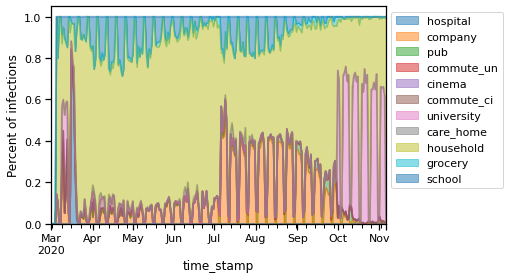

In [39]:
locations_per_day.plot.area( alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Percent of infections')

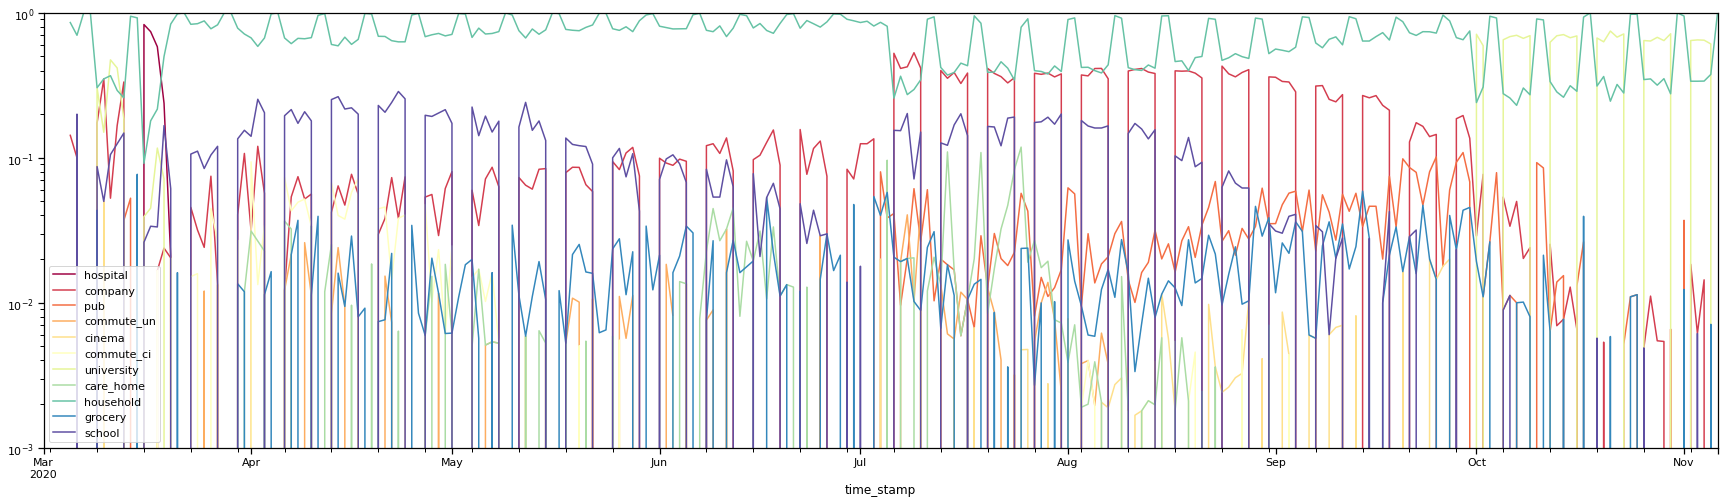

In [40]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

locations_per_day.plot(figsize=(30,8), logy=True, ylim=(1e-3, 1), cmap=cmap)

Text(0.5, 0, 'location')

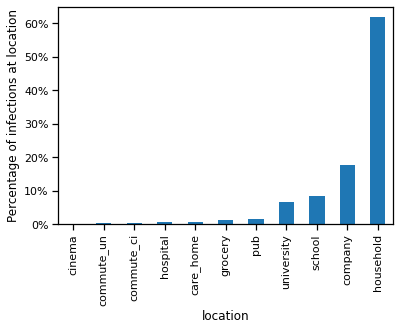

In [41]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')
#plt.yscale('log')

## rate of infection

In [42]:
r_df = read.get_r()

/home/florpi/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/florpi/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'R')

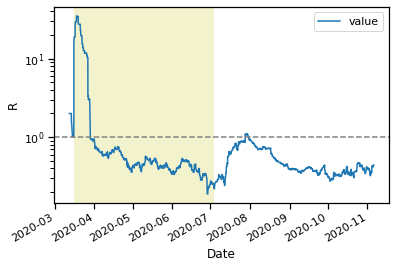

In [43]:
r_df.plot()
plt.axvspan(policies.social_distancing_start, 
            policies.social_distancing_end,
            facecolor='y', alpha=0.2)
plt.axhline(y=1, linestyle='dashed', color='gray')
plt.xlabel('Date')
plt.yscale('log')
plt.ylabel('R')

## World infection curves, and by super area

In [44]:
world_df = read.world_summary()

In [45]:
import matplotlib.pyplot as plt
 
plt.style.use(['science','notebook'])
plt.style.reload_library()

In [46]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

Text(0.5, 0, 'Date')

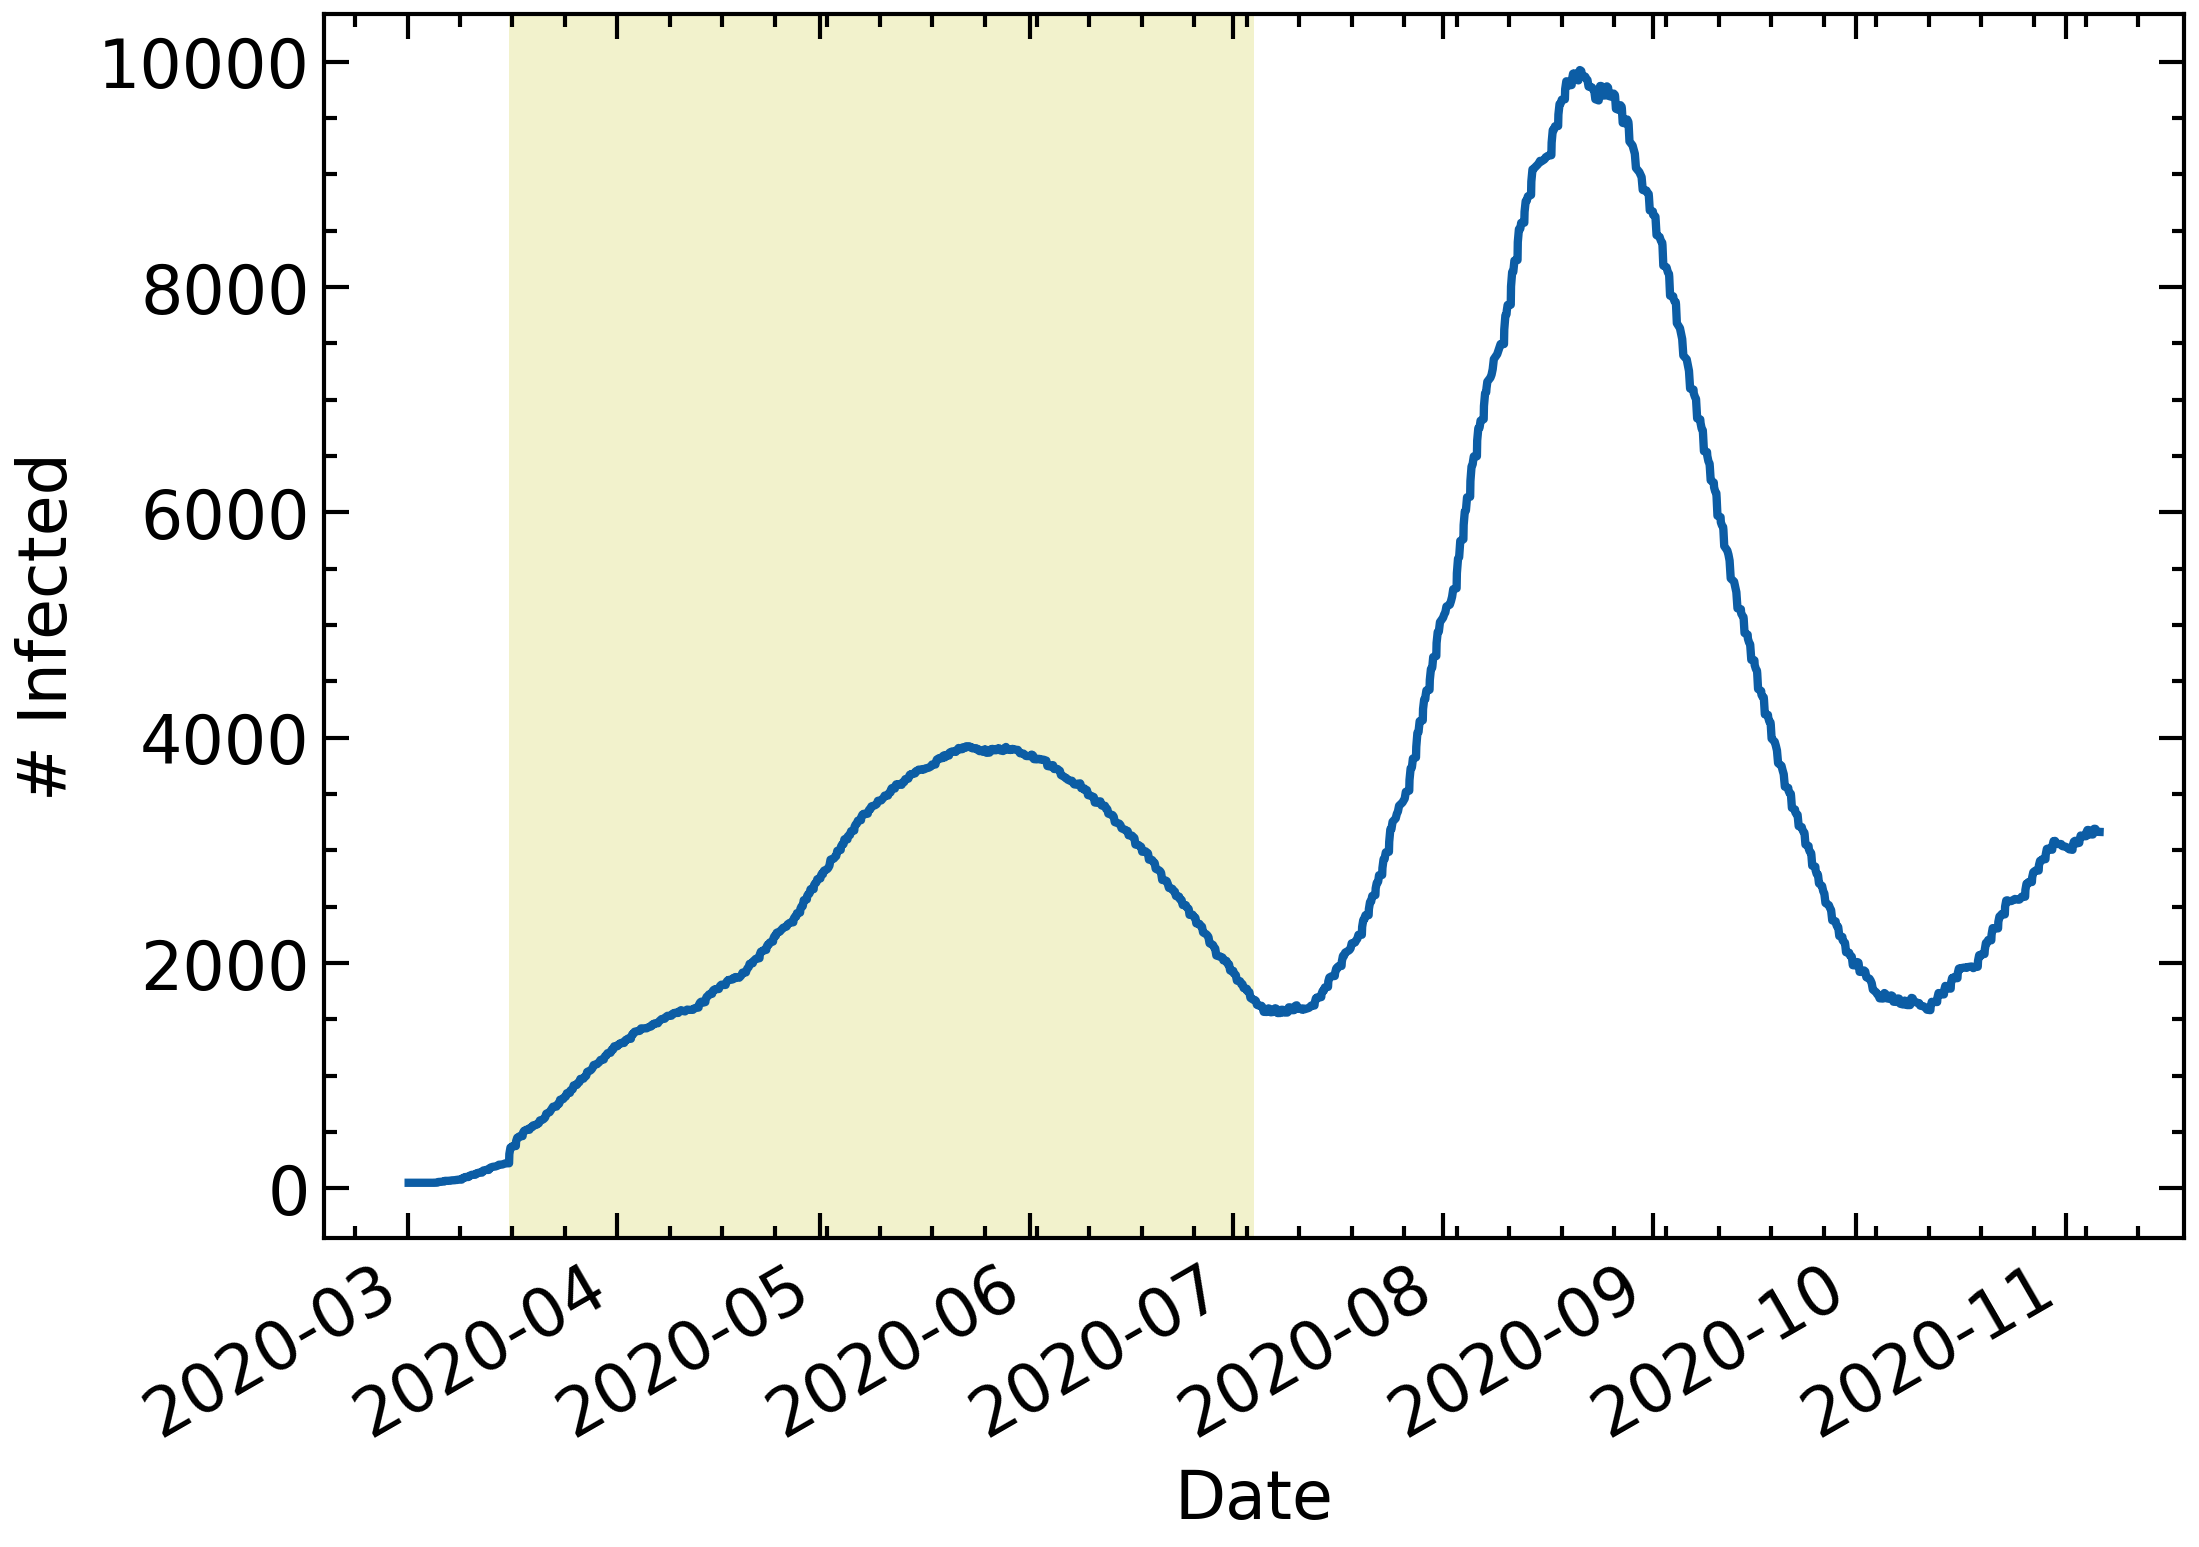

In [47]:
fig, ax = plt.subplots()
world_df['infected'].plot(ax=ax)
ax.axvspan(policies.social_distancing_start, 
            policies.social_distancing_end,
            facecolor='y', alpha=0.2)
ax.set_ylabel('# Infected')
ax.set_xlabel('Date')

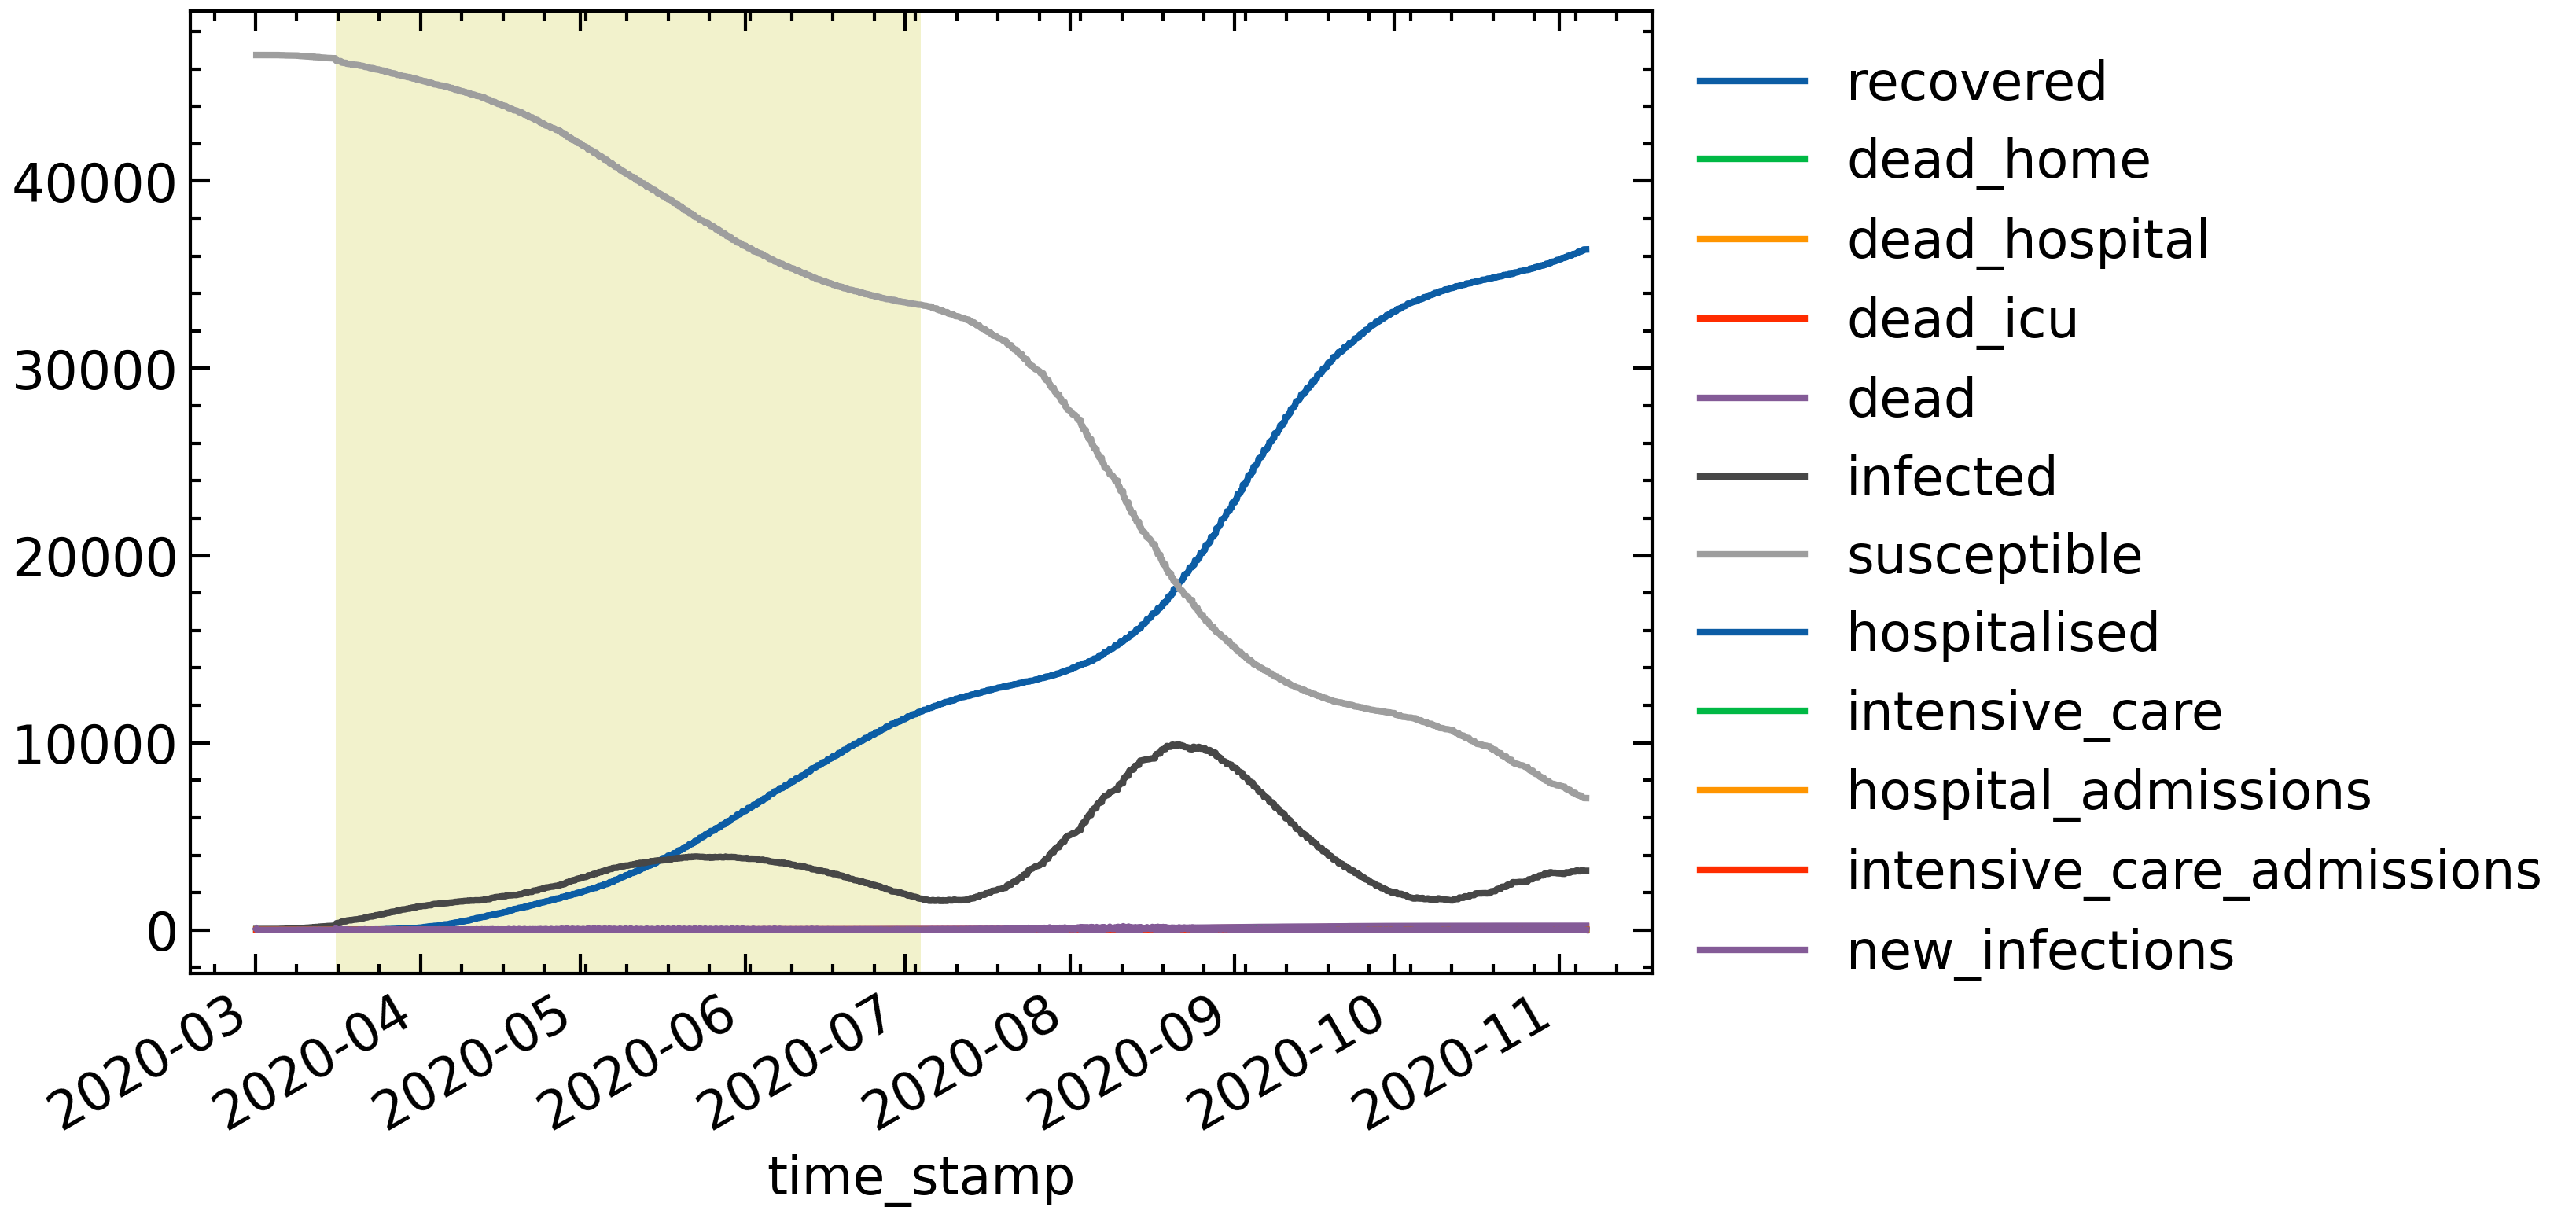

In [48]:
world_df.plot()
plt.axvspan(policies.social_distancing_start, 
            policies.social_distancing_end,
            facecolor='y', alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


In [49]:
area_df = read.super_area_summary()

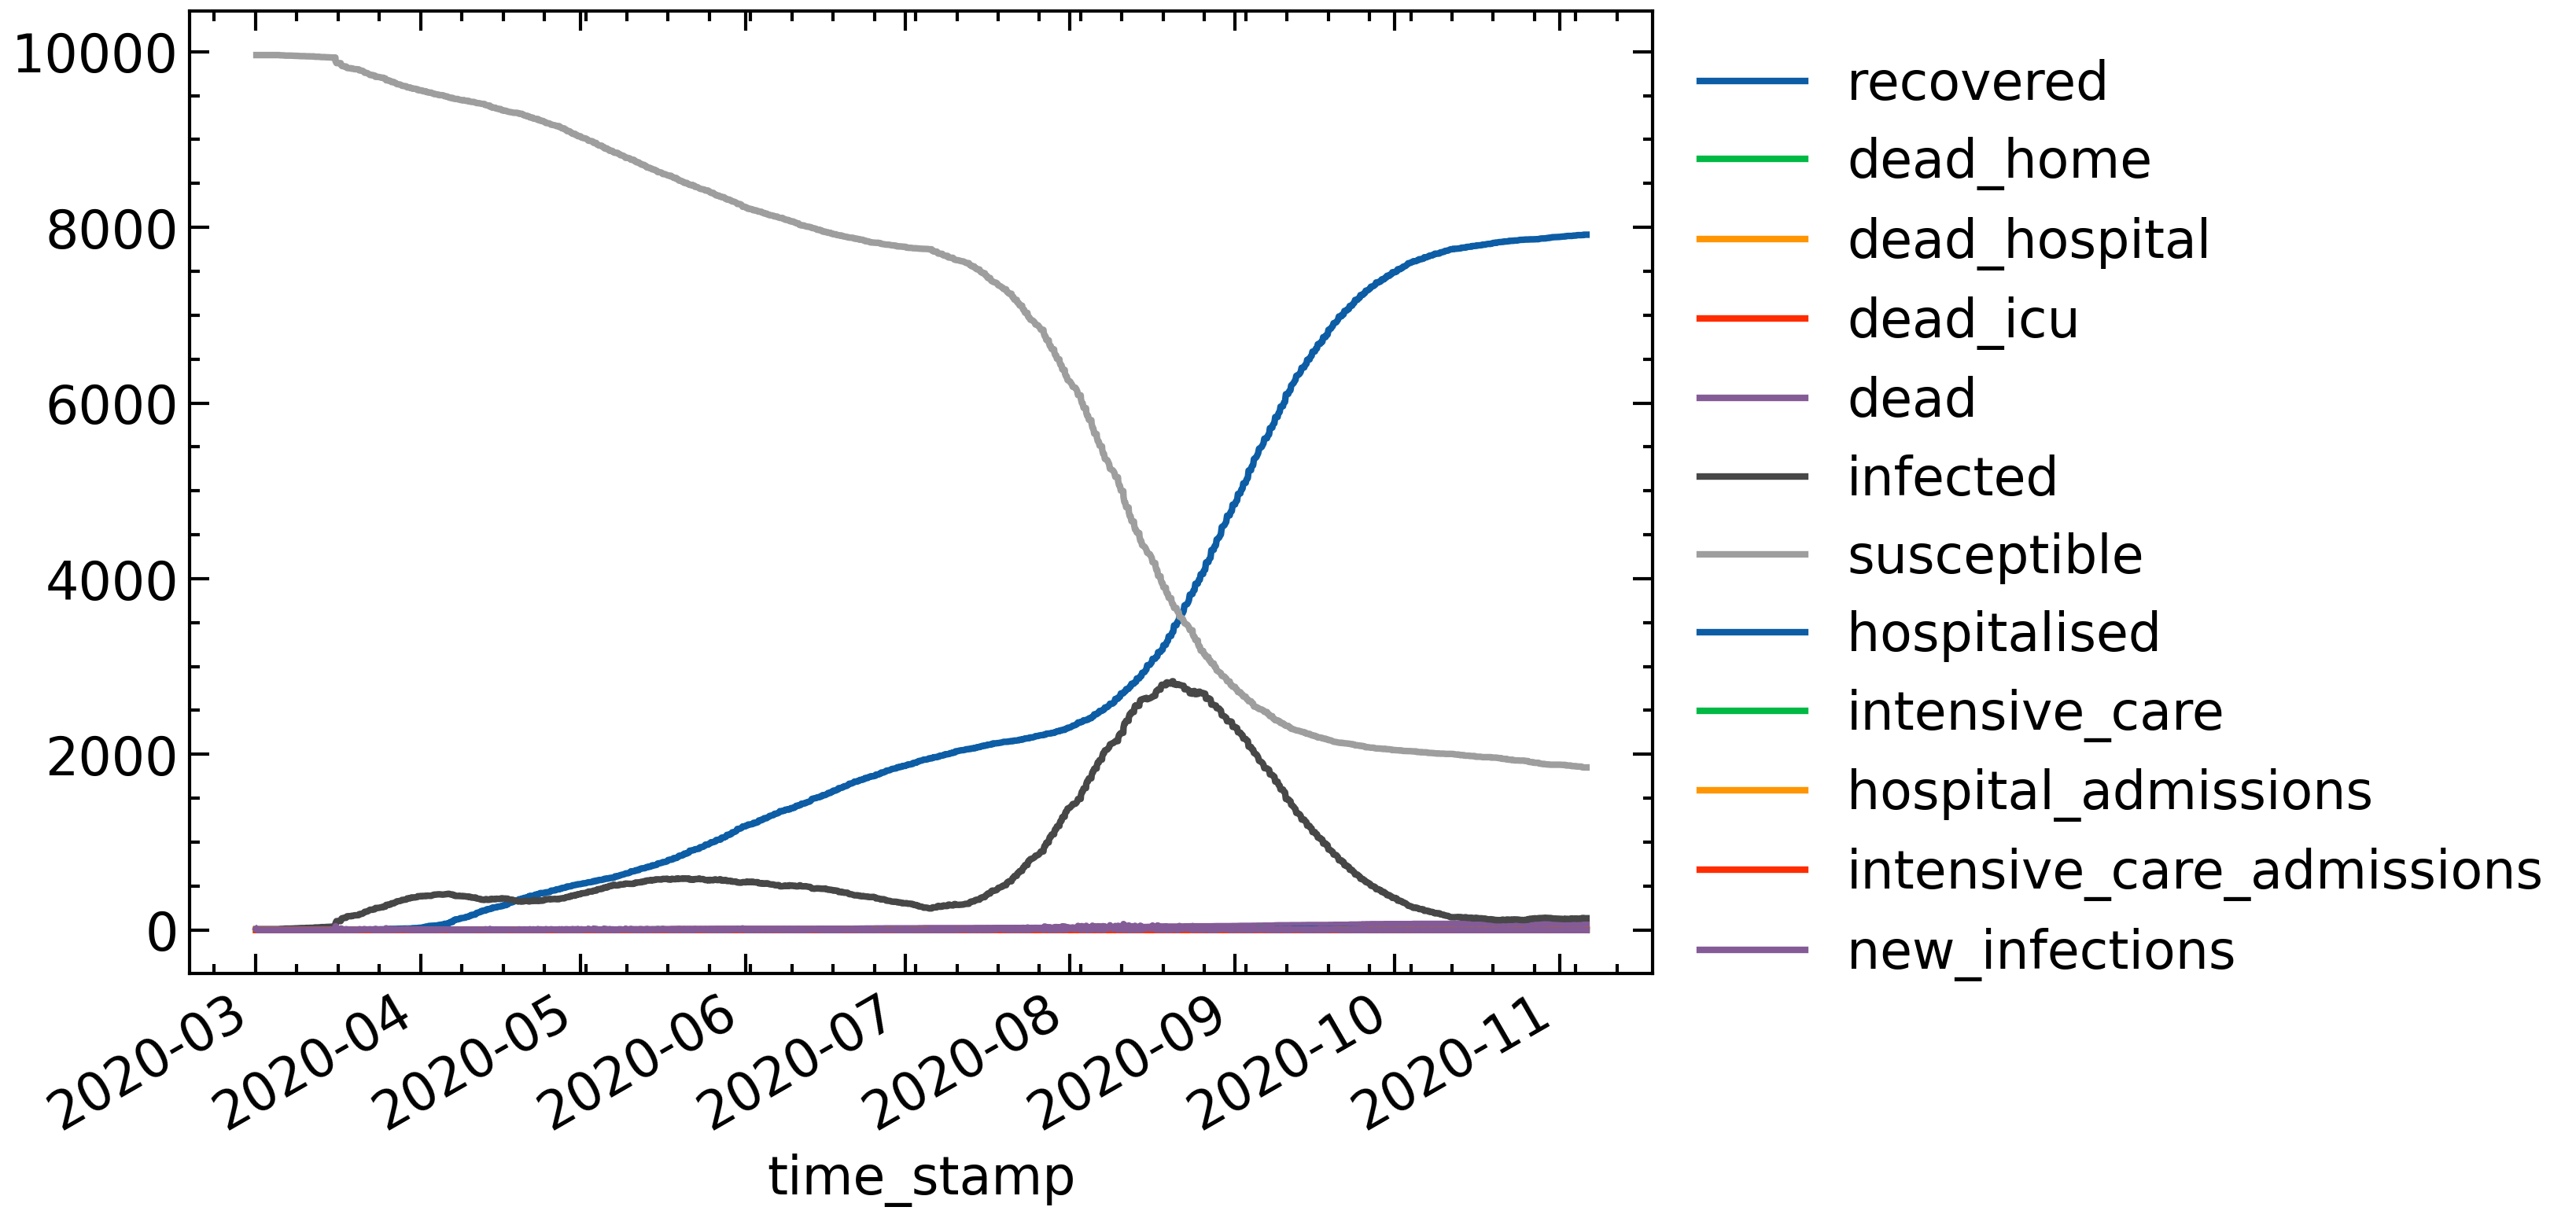

In [50]:
area_df[area_df.super_area == "E02003282"].plot()
plt.legend(bbox_to_anchor=(1,1))



## World infection curves per age group

In [51]:
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

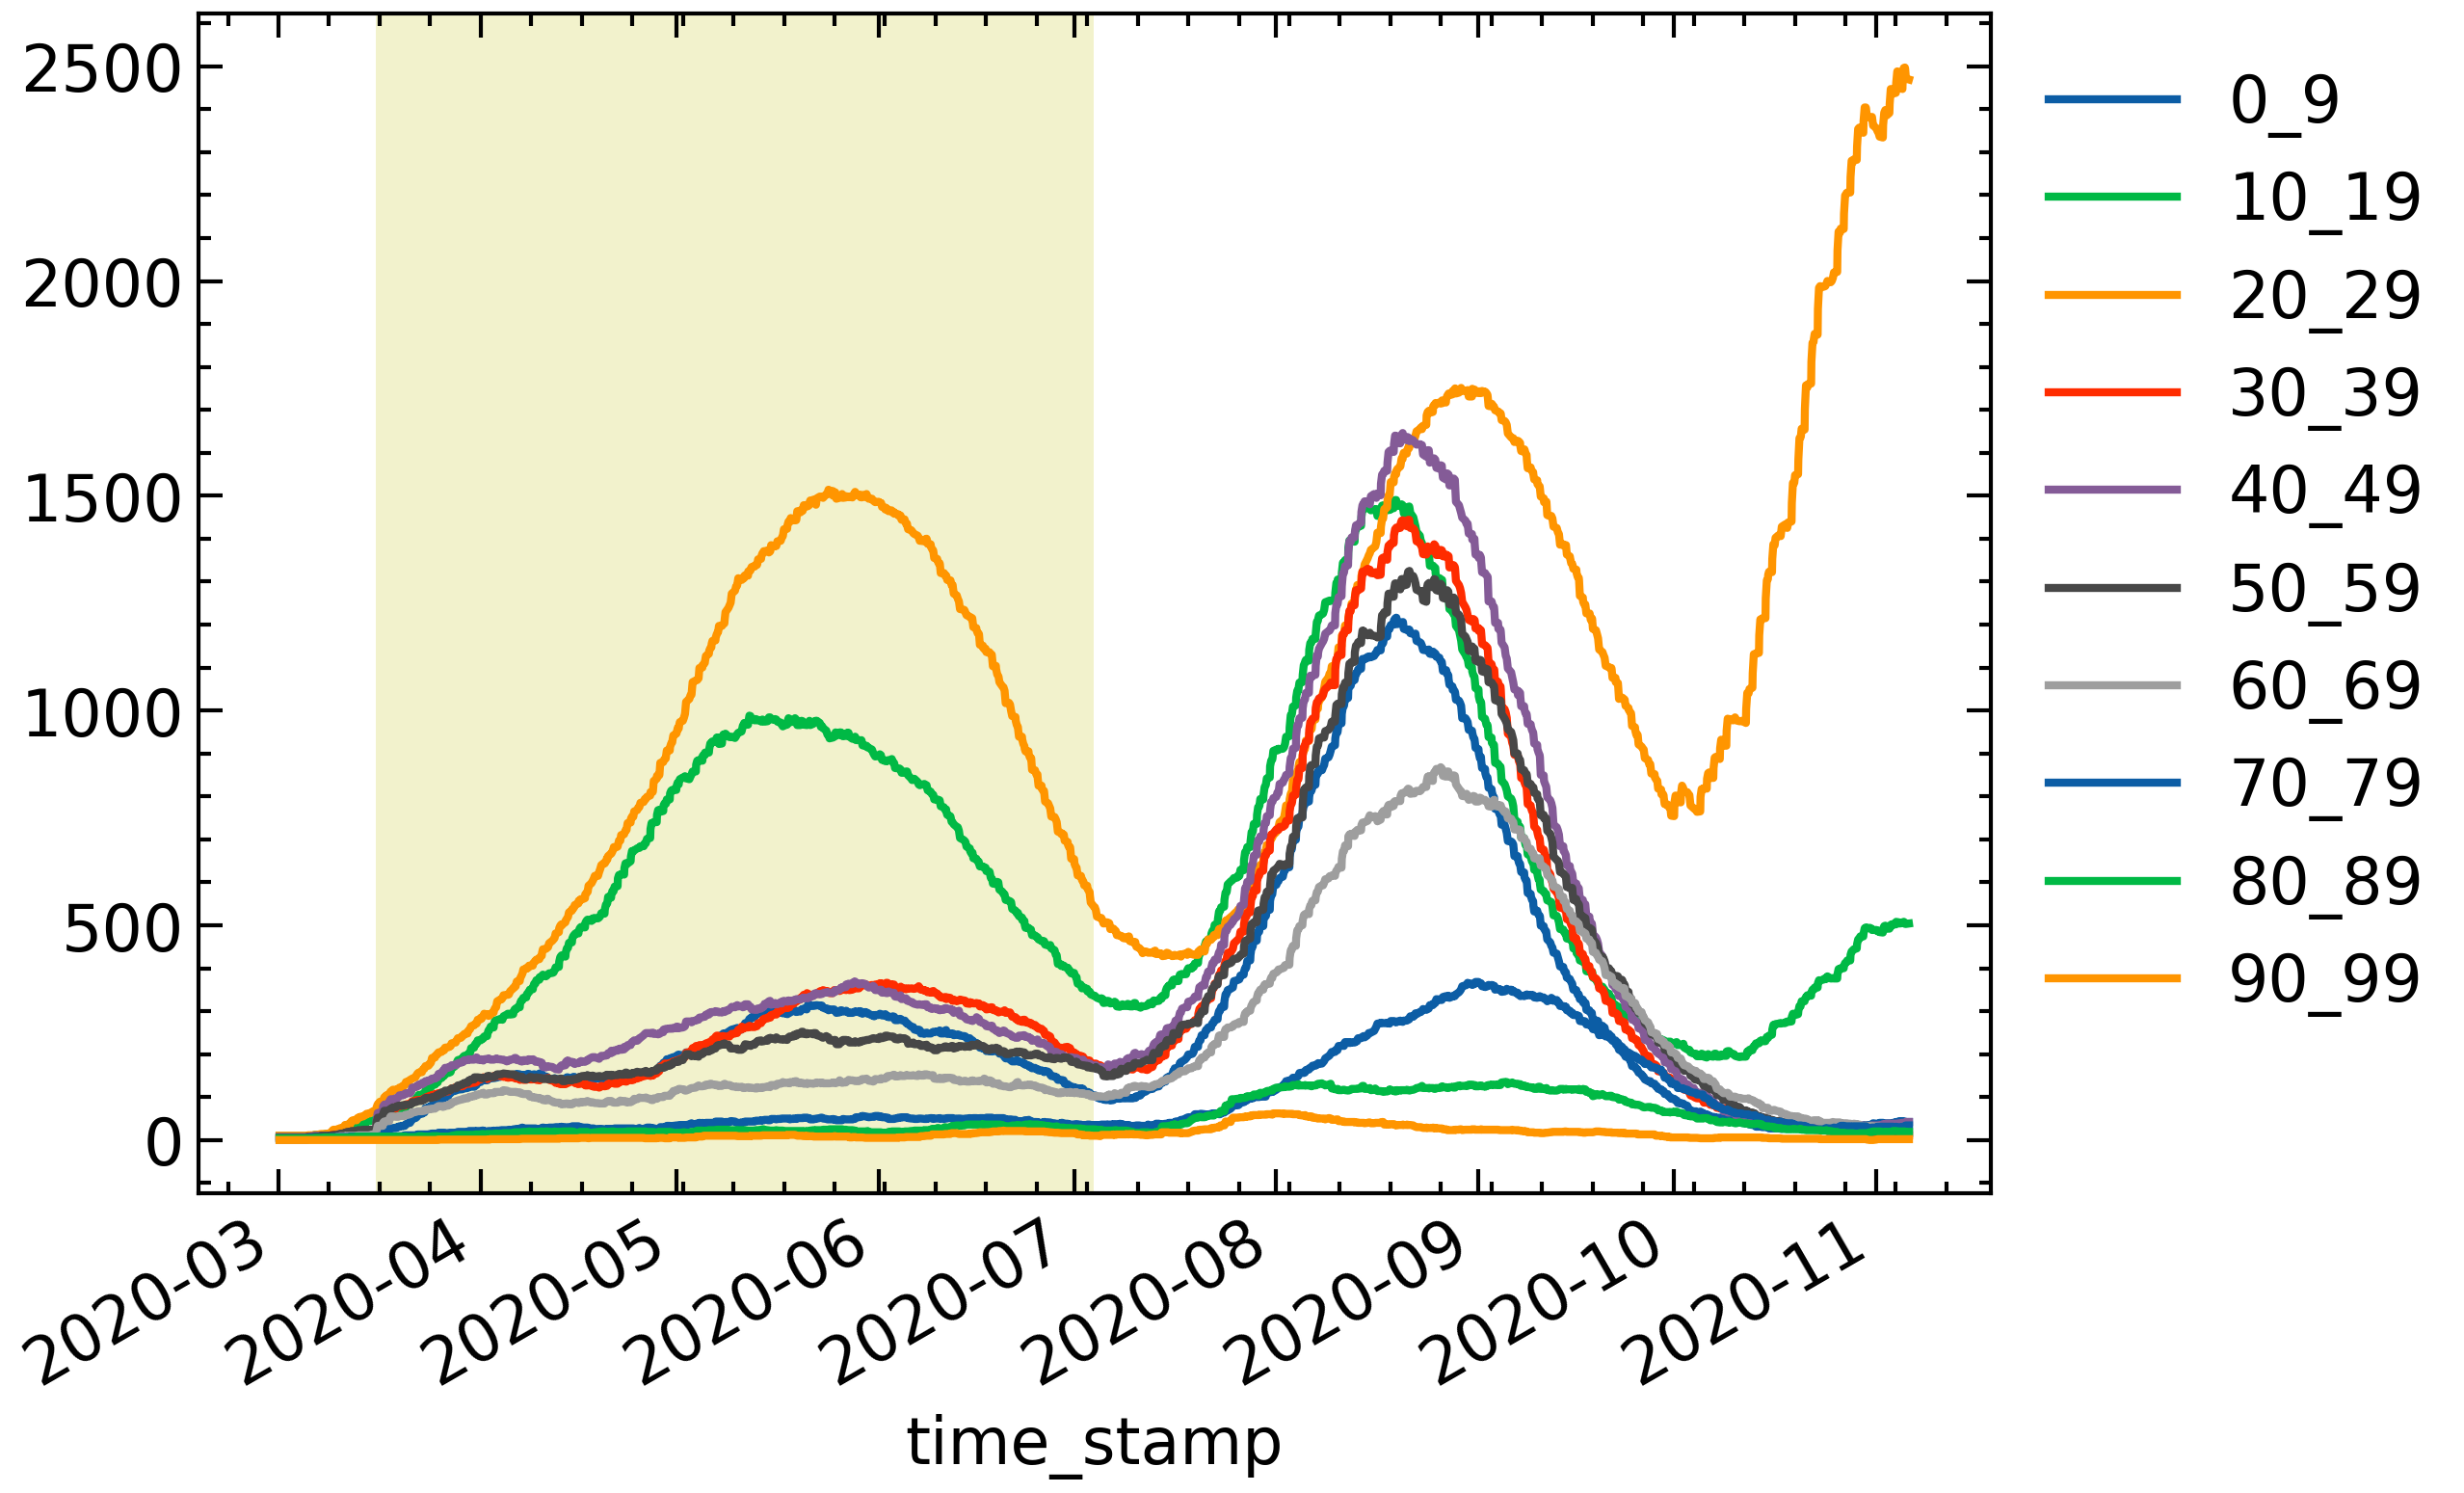

In [52]:
for name, group in ages_df.groupby('age_range'):
    group['infected'].plot(label=name)
plt.axvspan(policies.social_distancing_start, 
            policies.social_distancing_end,
            facecolor='y', alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


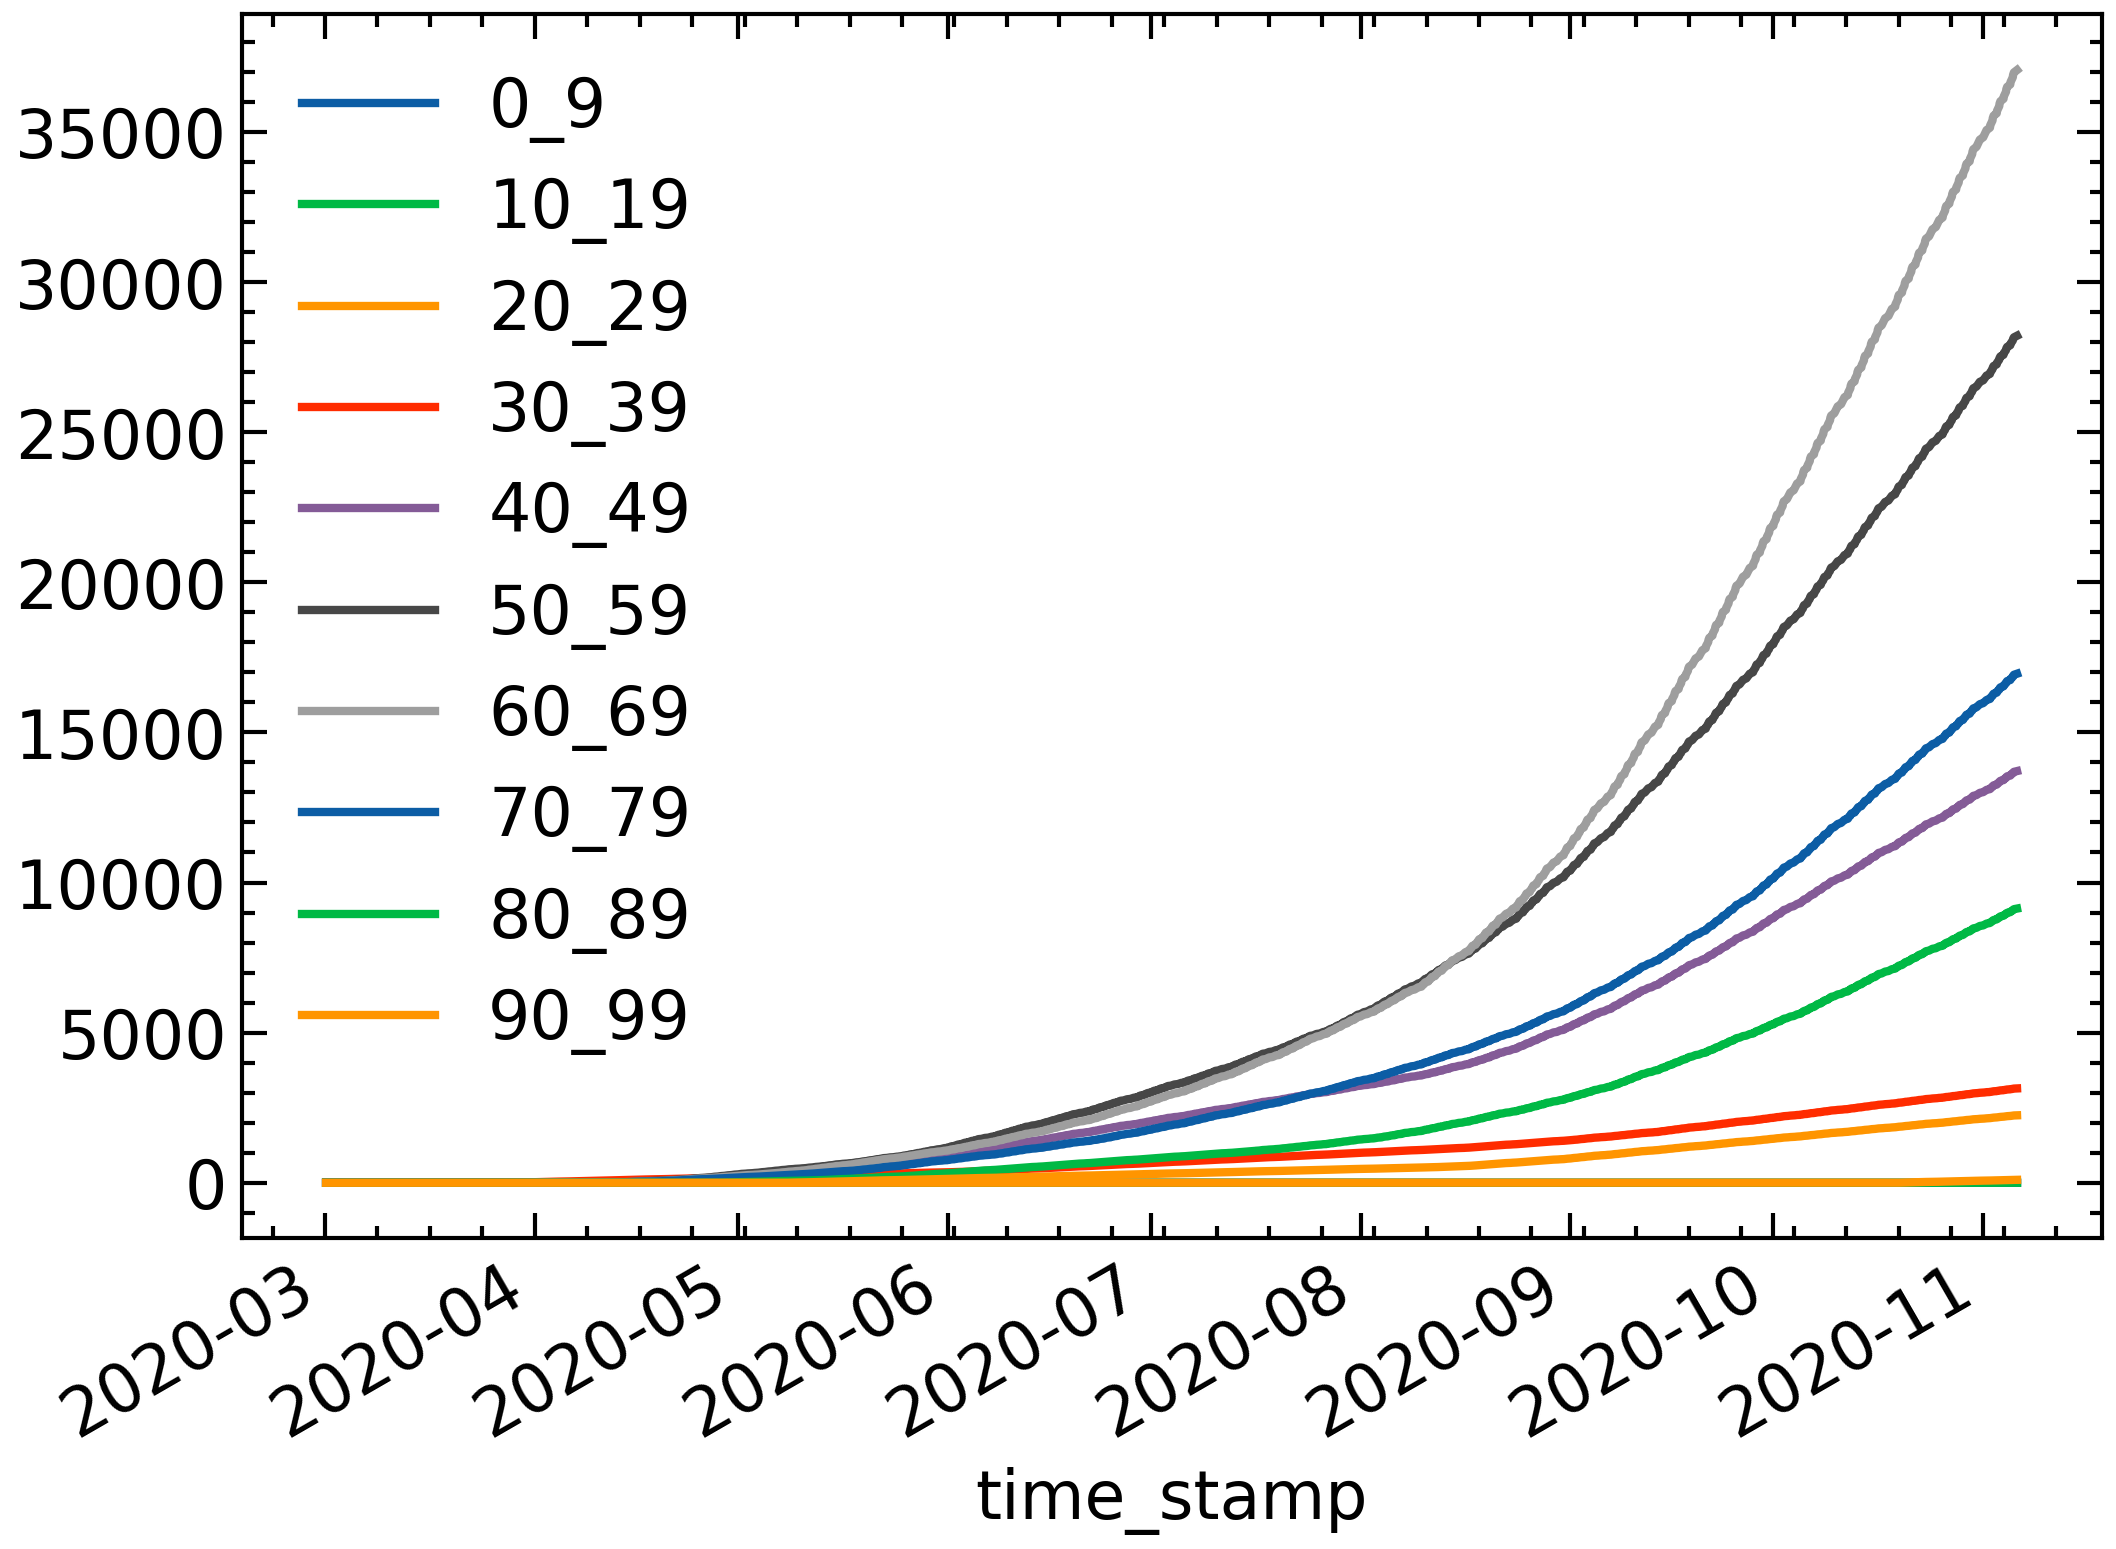

In [53]:
for name, group in ages_df.groupby('age_range'):
    group['dead'].cumsum().plot(label=name)
plt.legend()

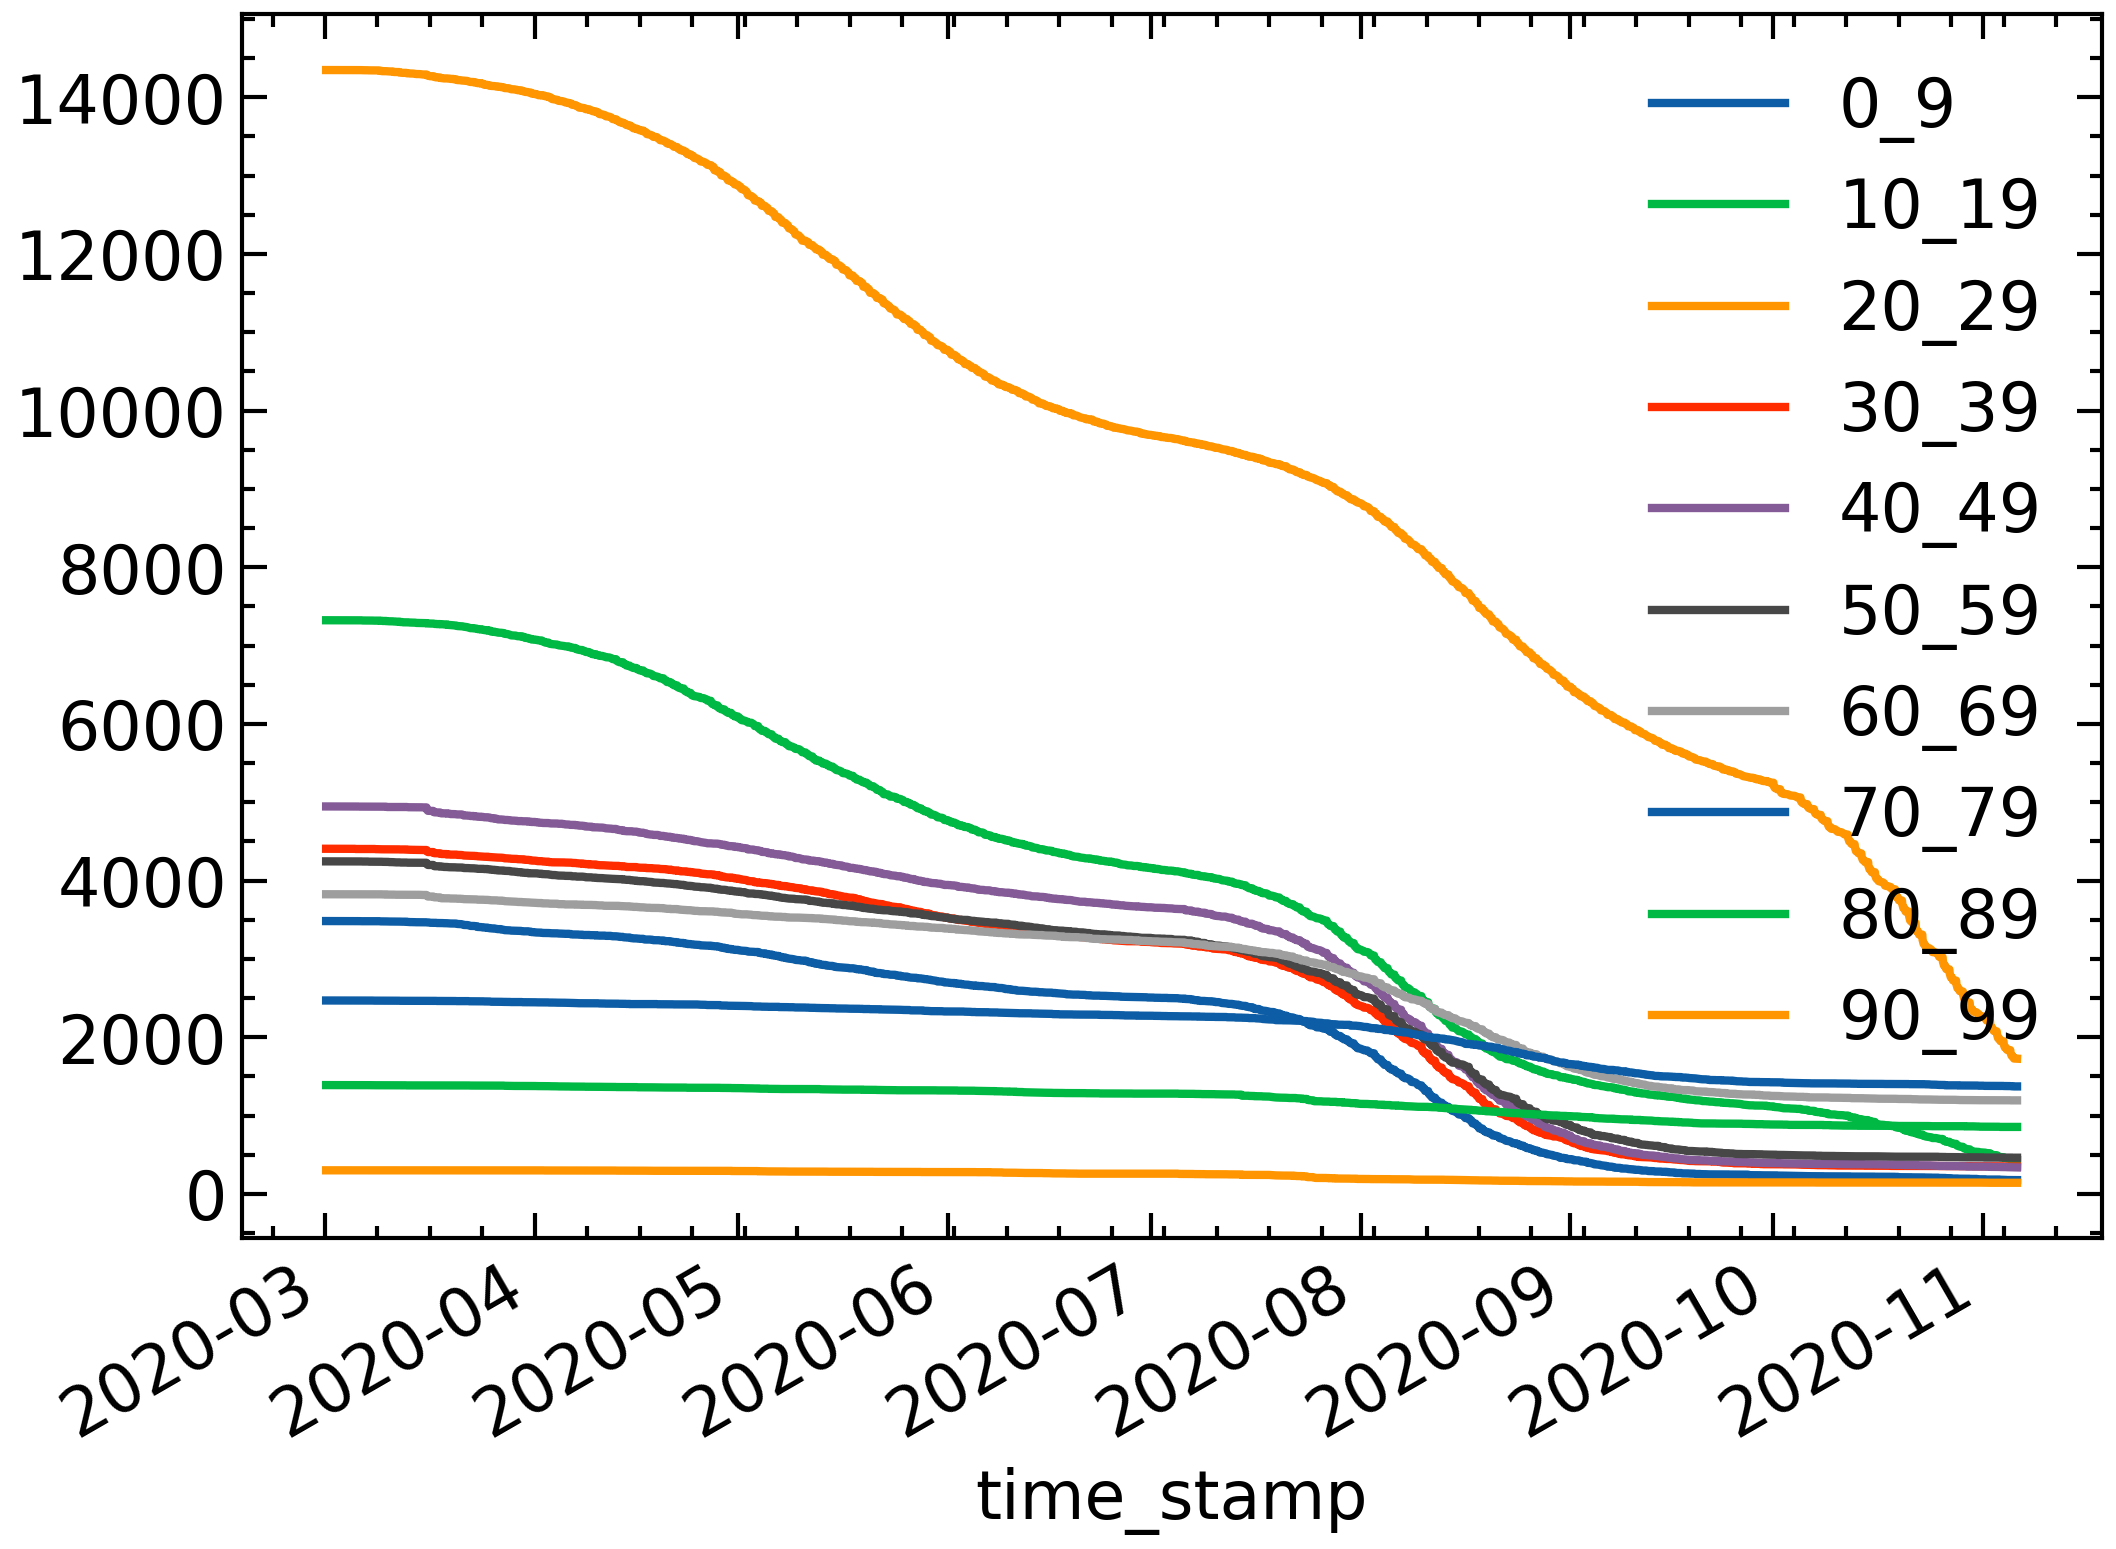

In [54]:
for name, group in ages_df.groupby('age_range'):
    group['susceptible'].plot(label=name)
plt.legend()

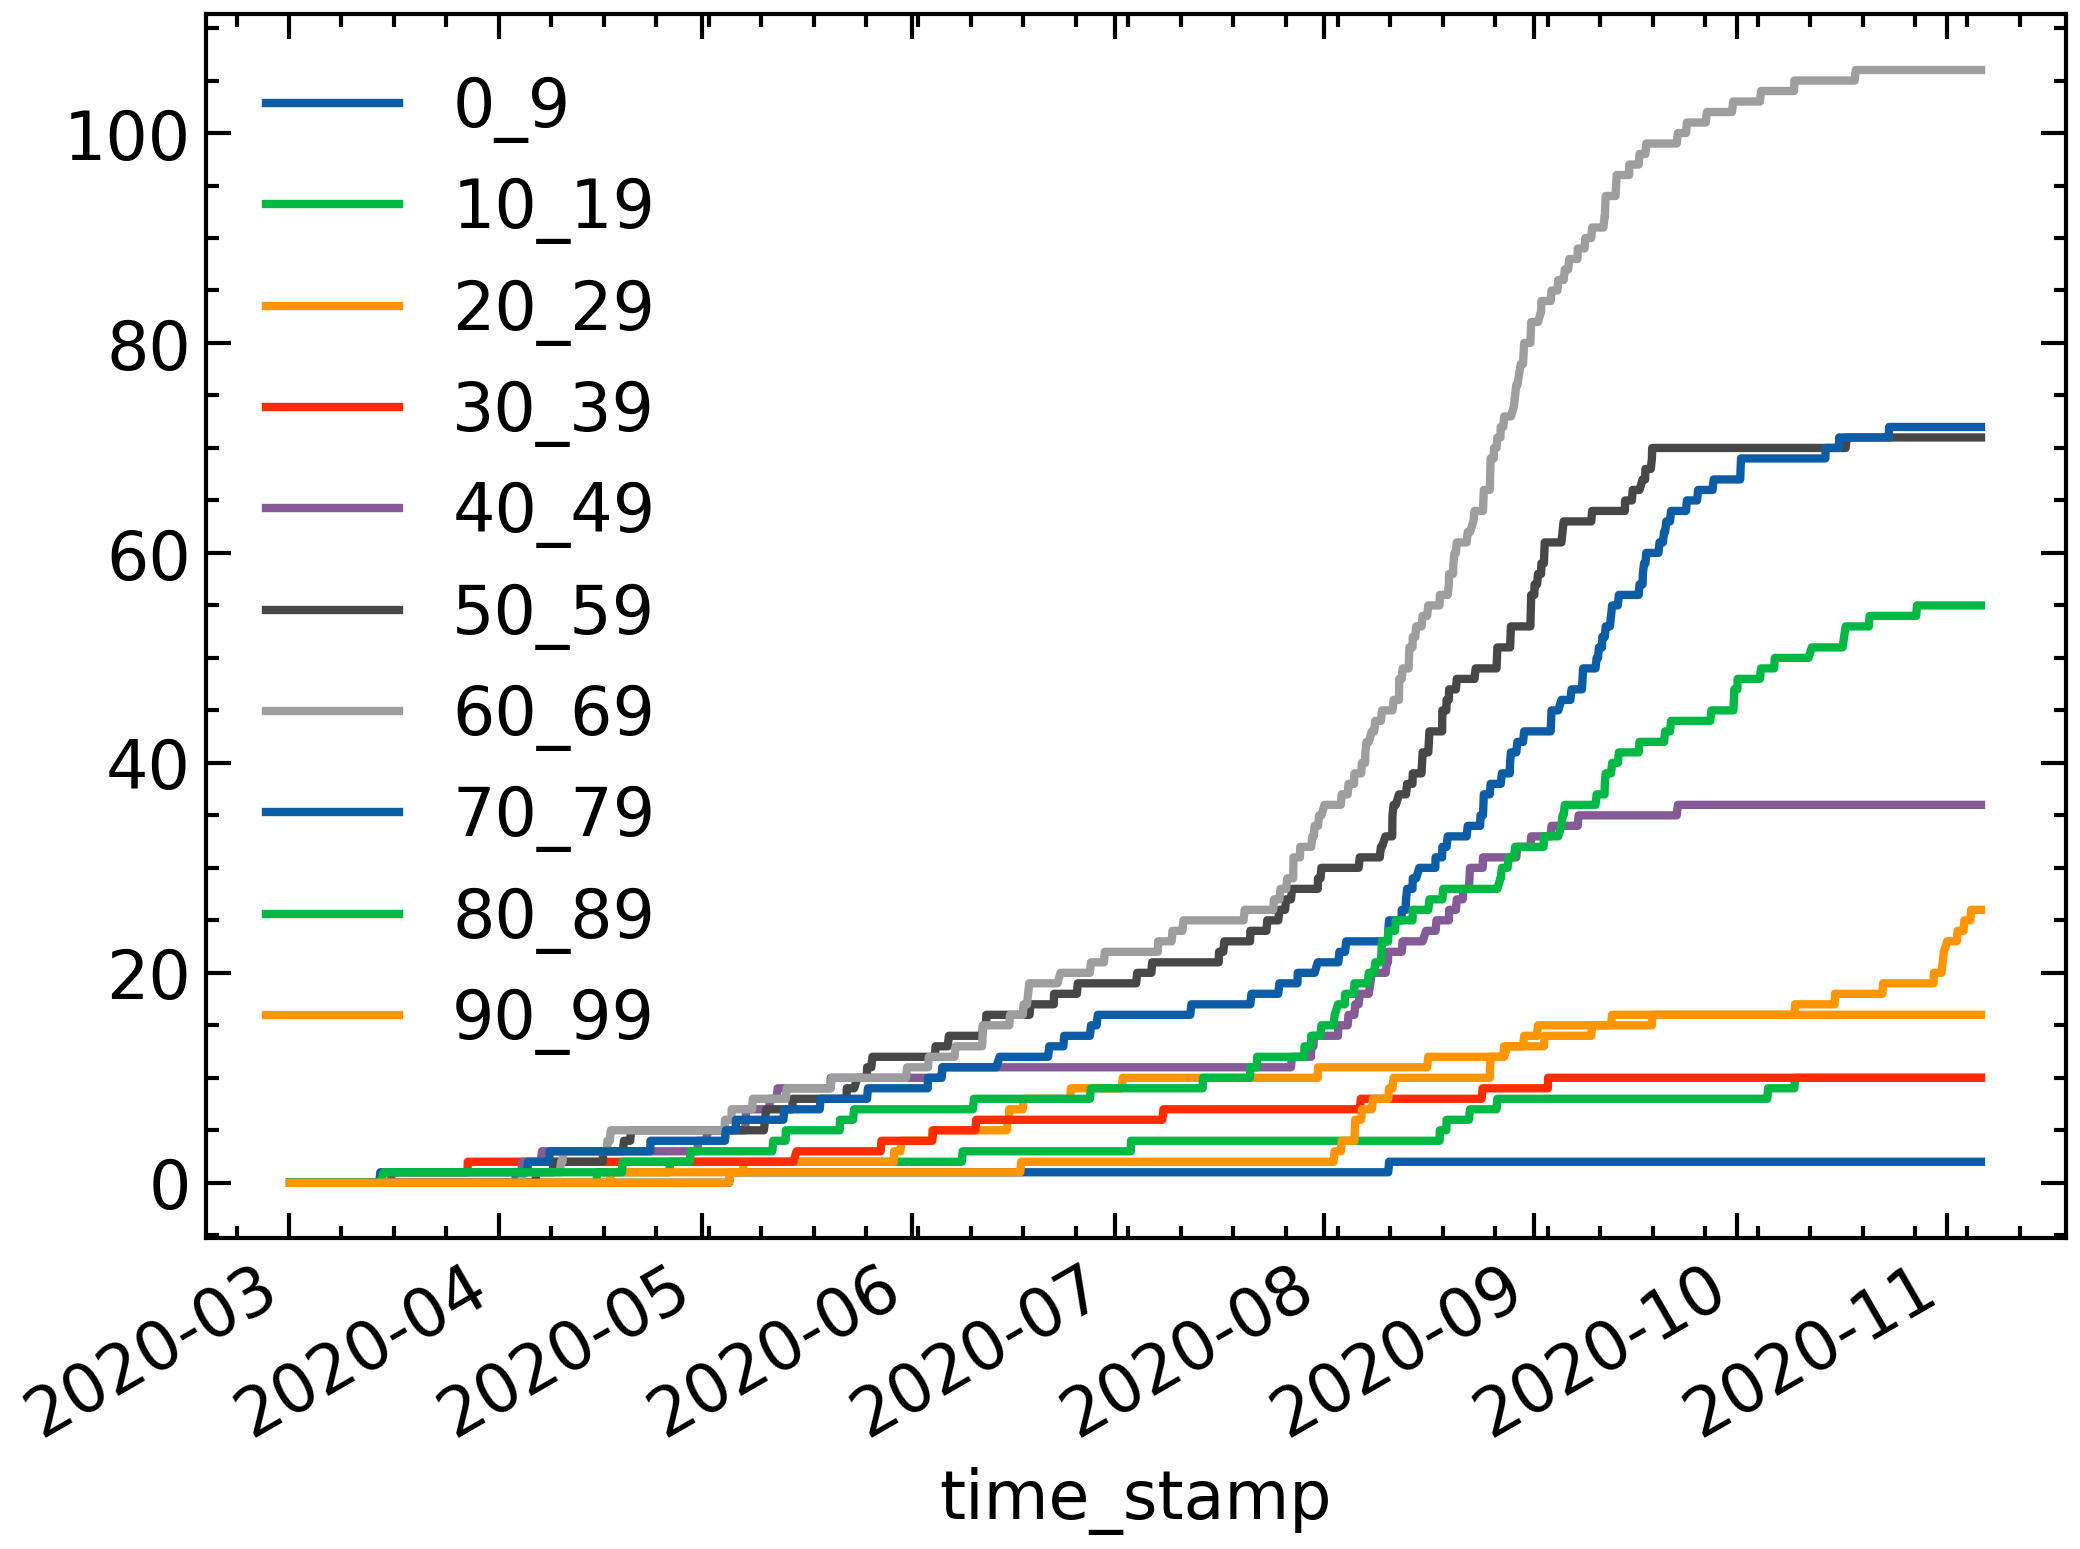

In [55]:
for name, group in ages_df.groupby('age_range'):
    group['hospital_admissions'].cumsum().plot(label=name)
plt.legend()

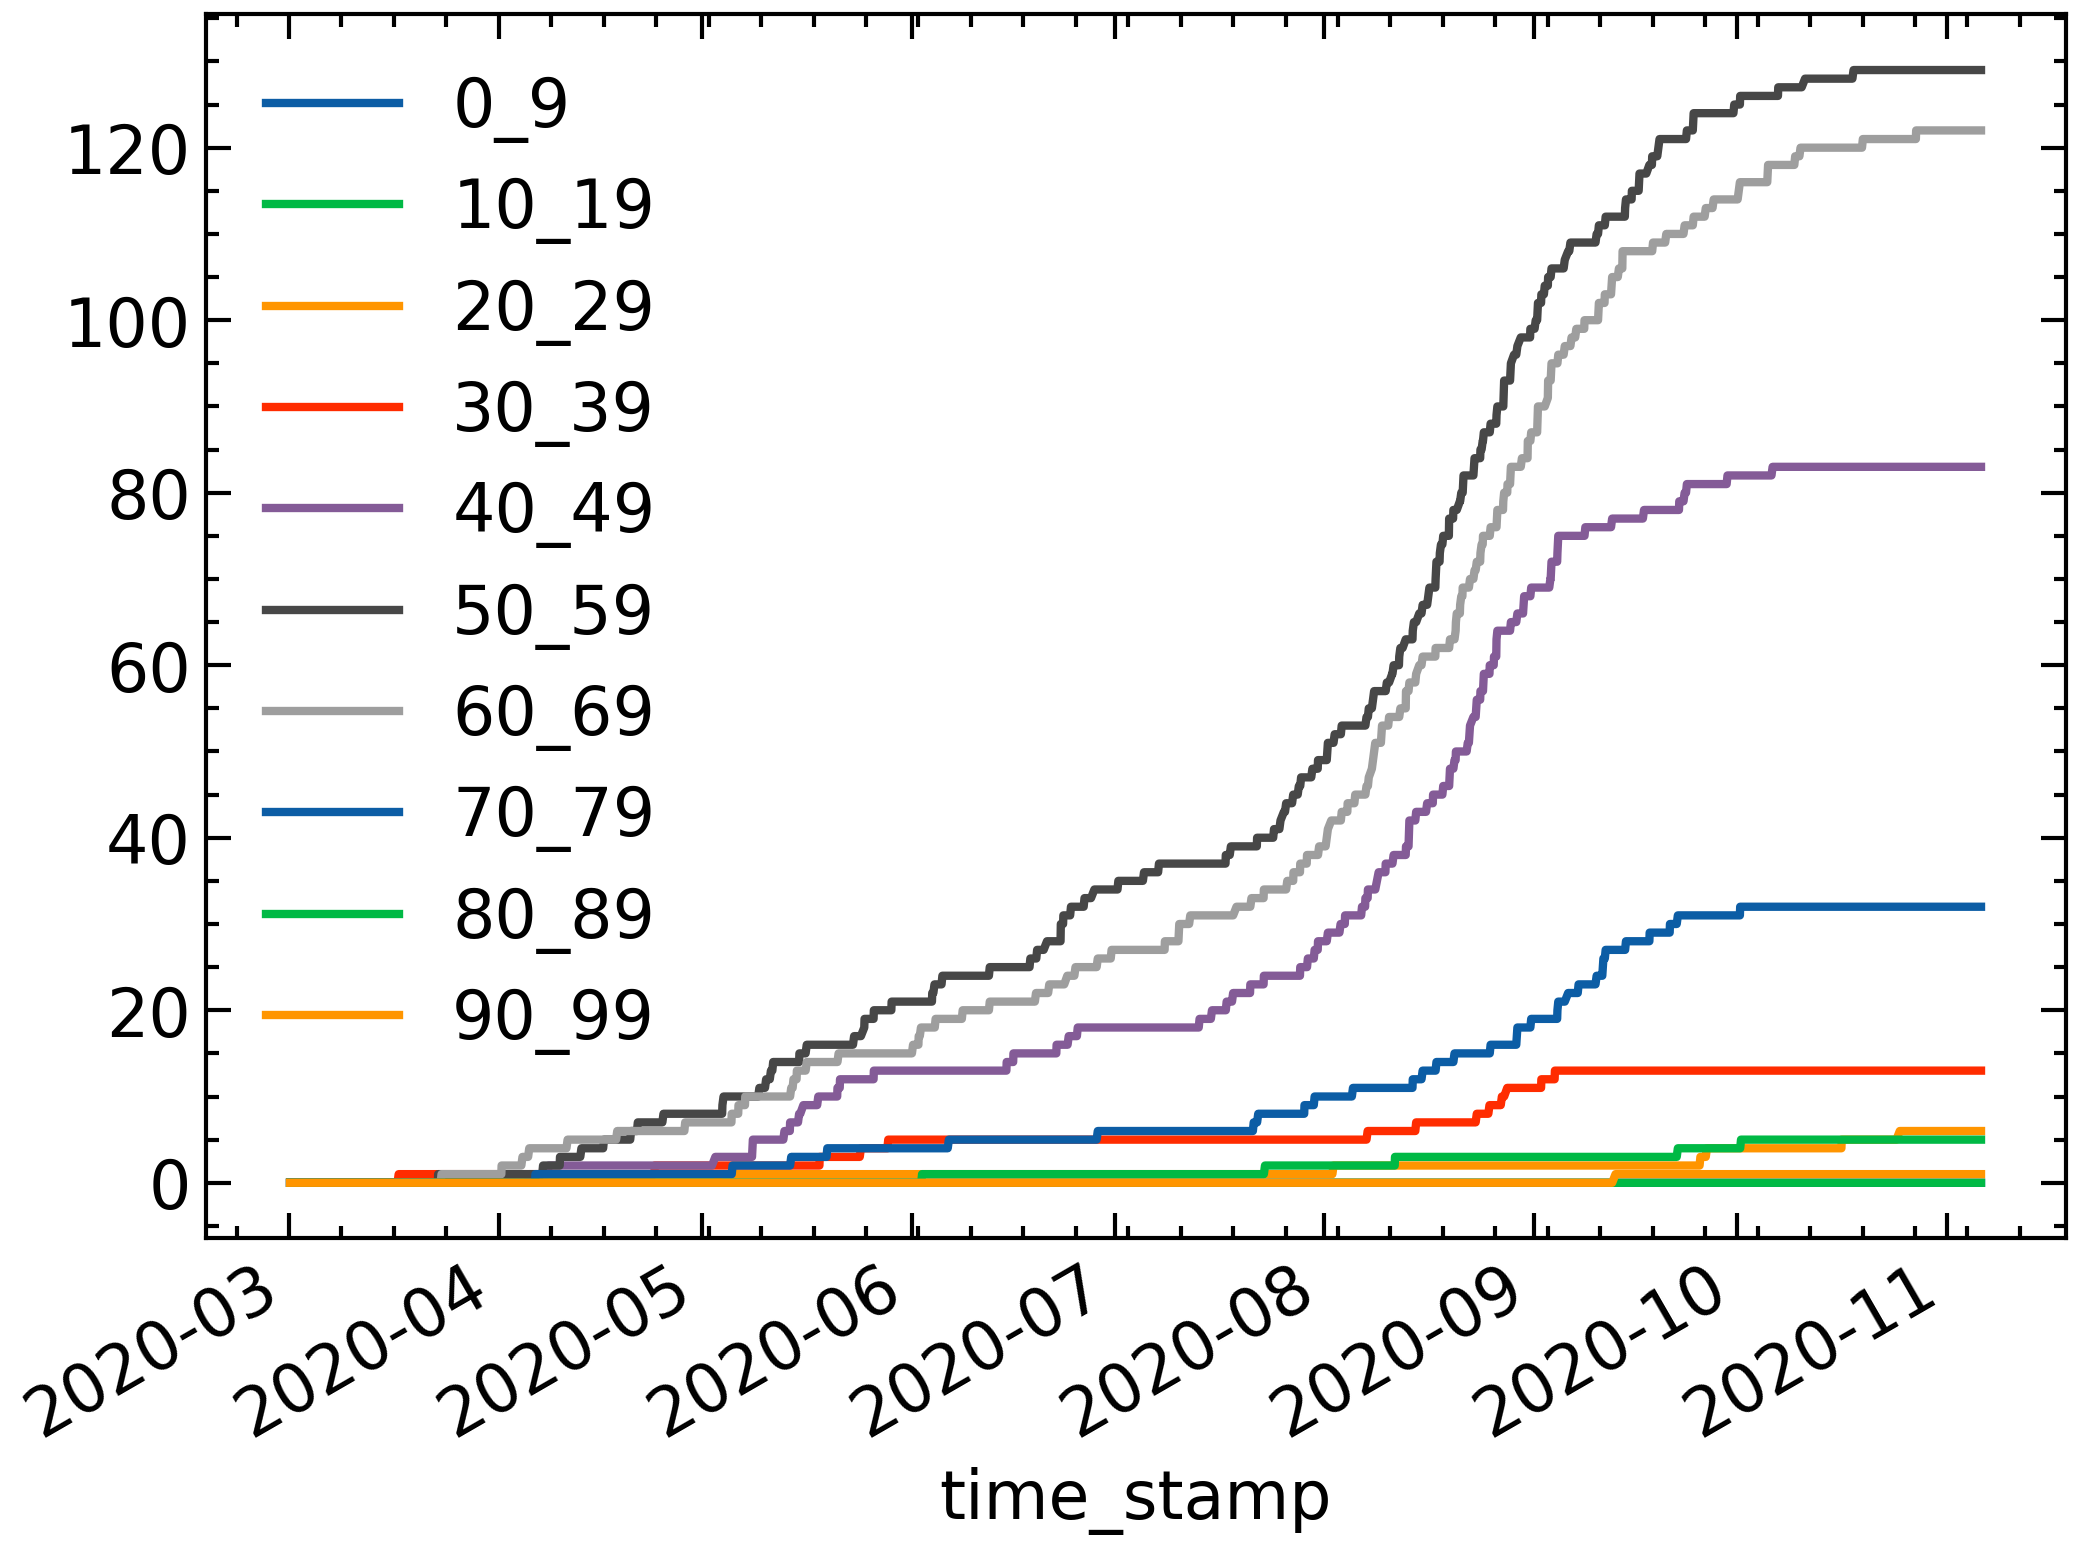

In [56]:
for name, group in ages_df.groupby('age_range'):
    group['intensive_care_admissions'].cumsum().plot(label=name)
plt.legend()

## Draw some of the symptoms trajectories

In [57]:
random_trajectories = read.draw_symptom_trajectories(window_length=600,
                                        n_people=10)

In [58]:
from june.infection import SymptomTag

In [59]:
symptoms_values = [tag.value for tag in SymptomTag]
symptoms_names = [tag.name for tag in SymptomTag]


Text(0.5, 0, 'Date')

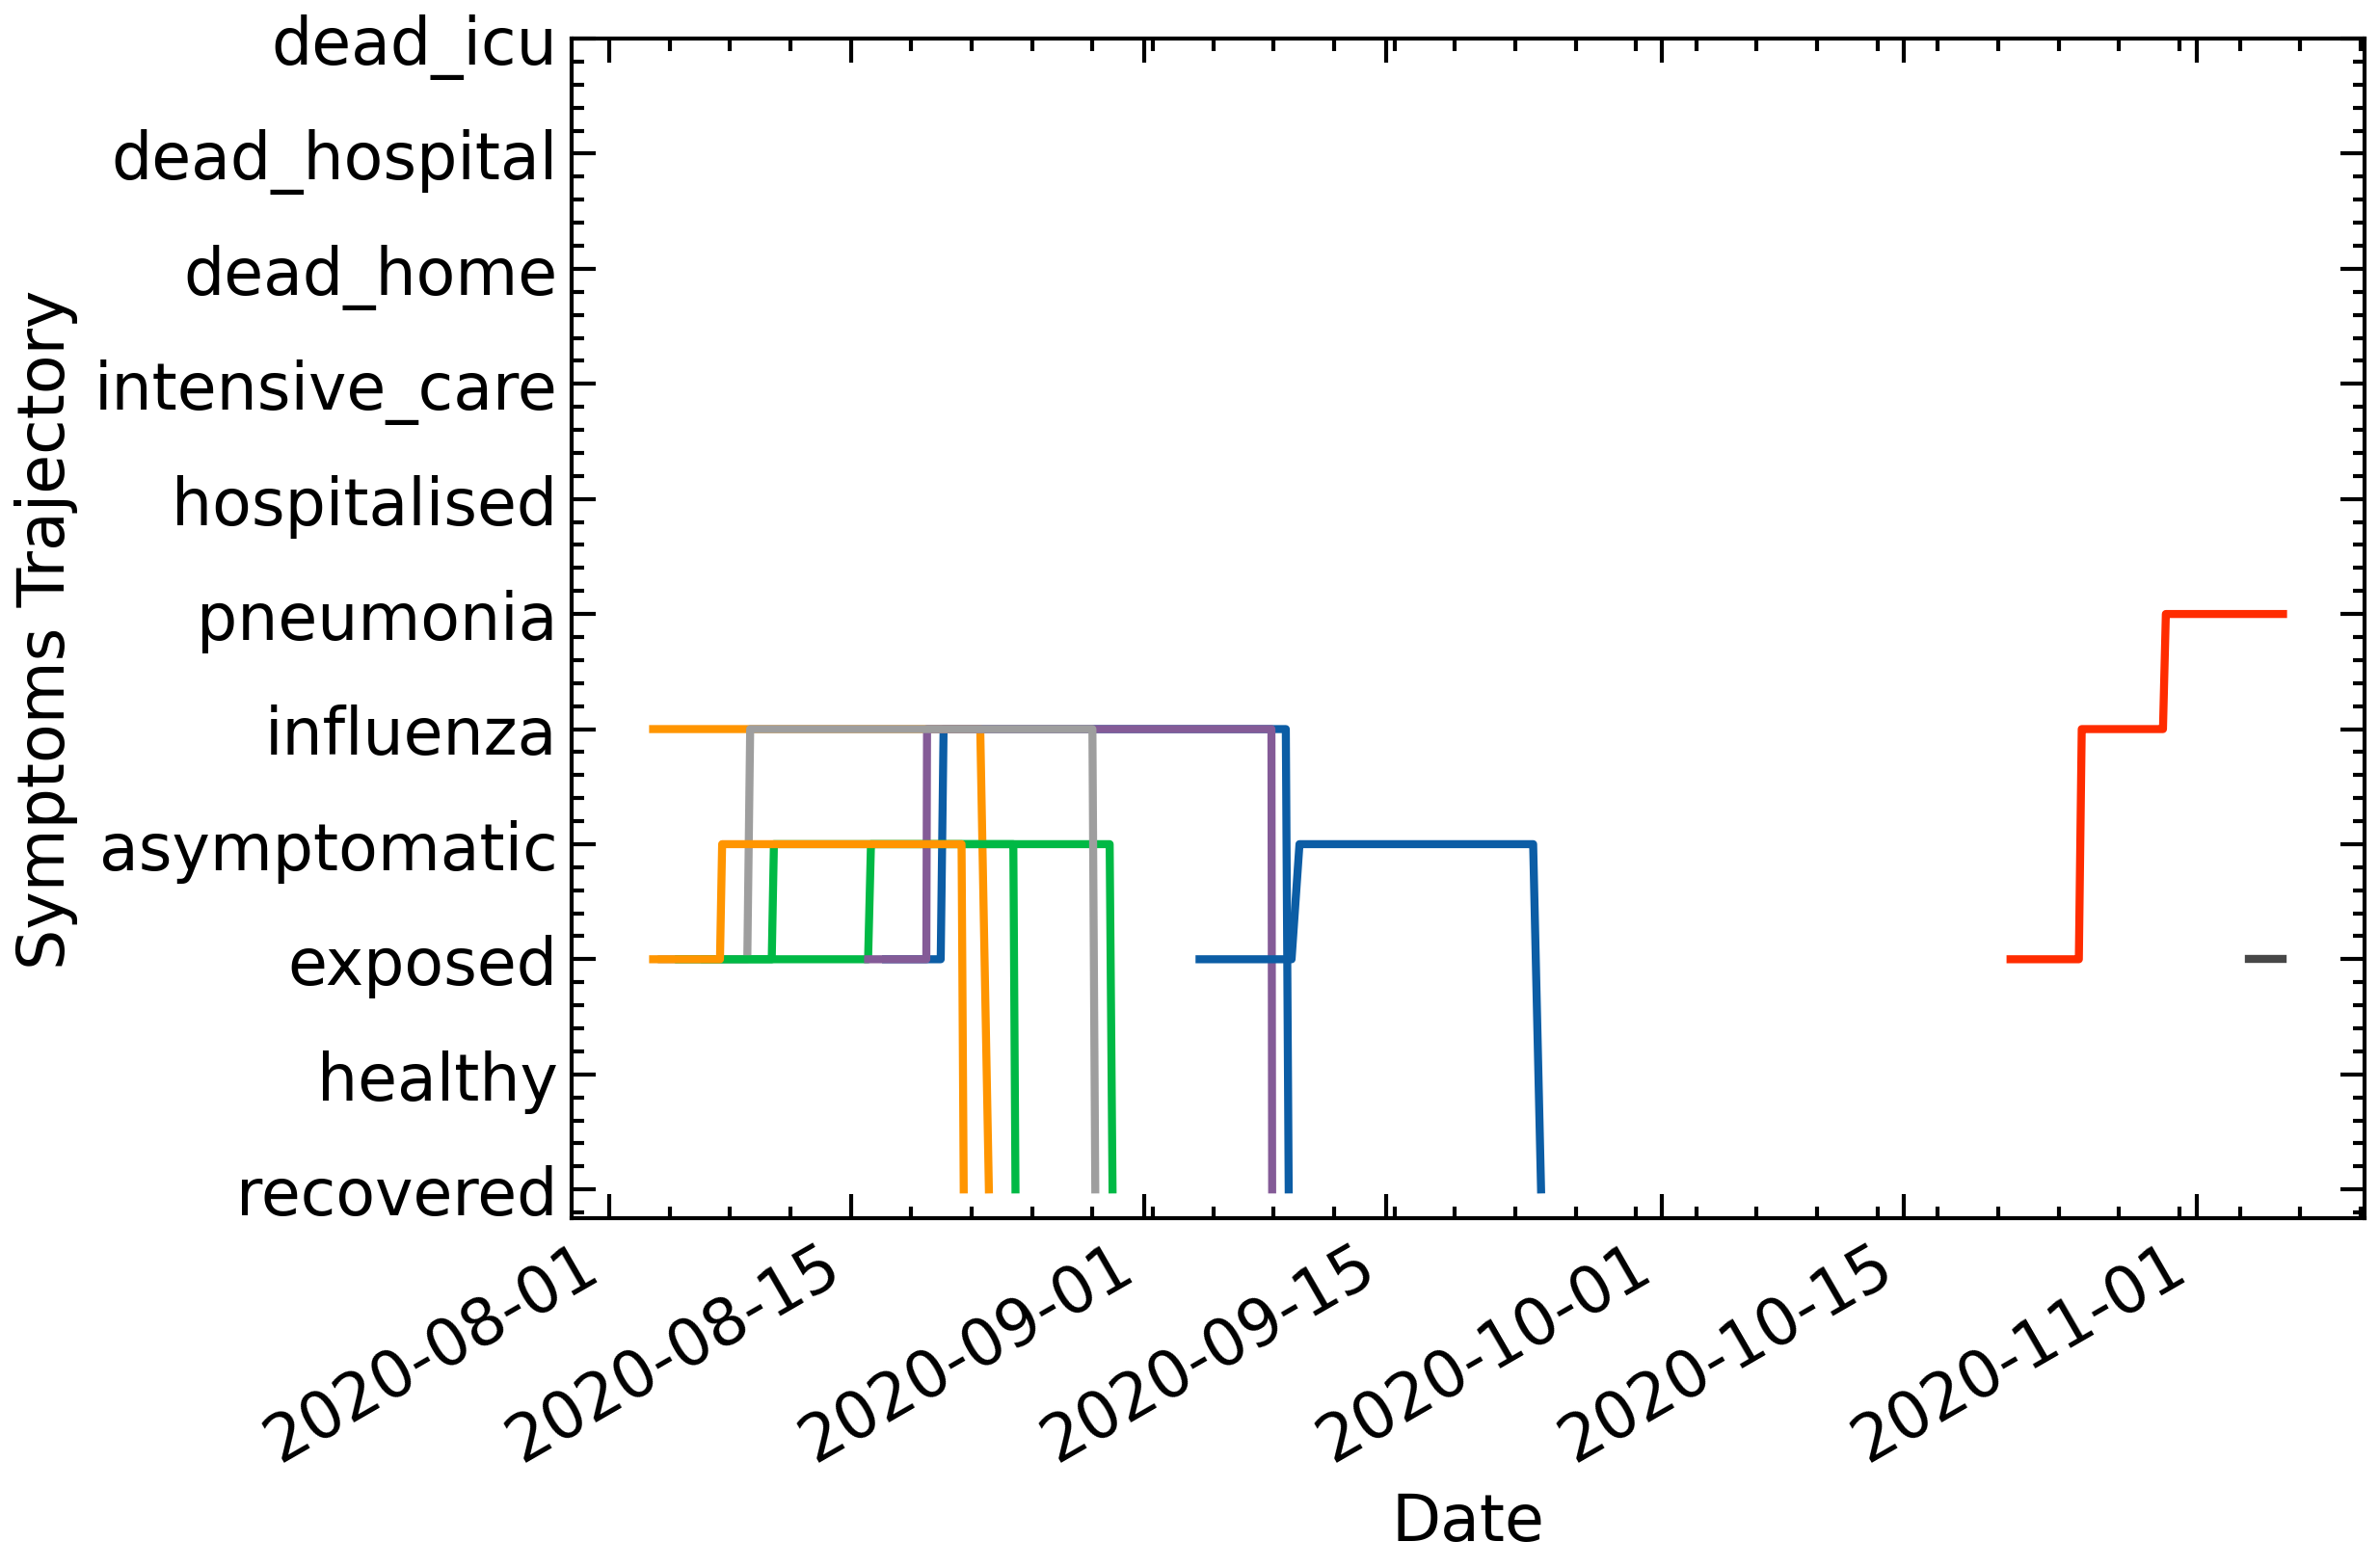

In [60]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
_ = plt.yticks(symptoms_values, symptoms_names)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

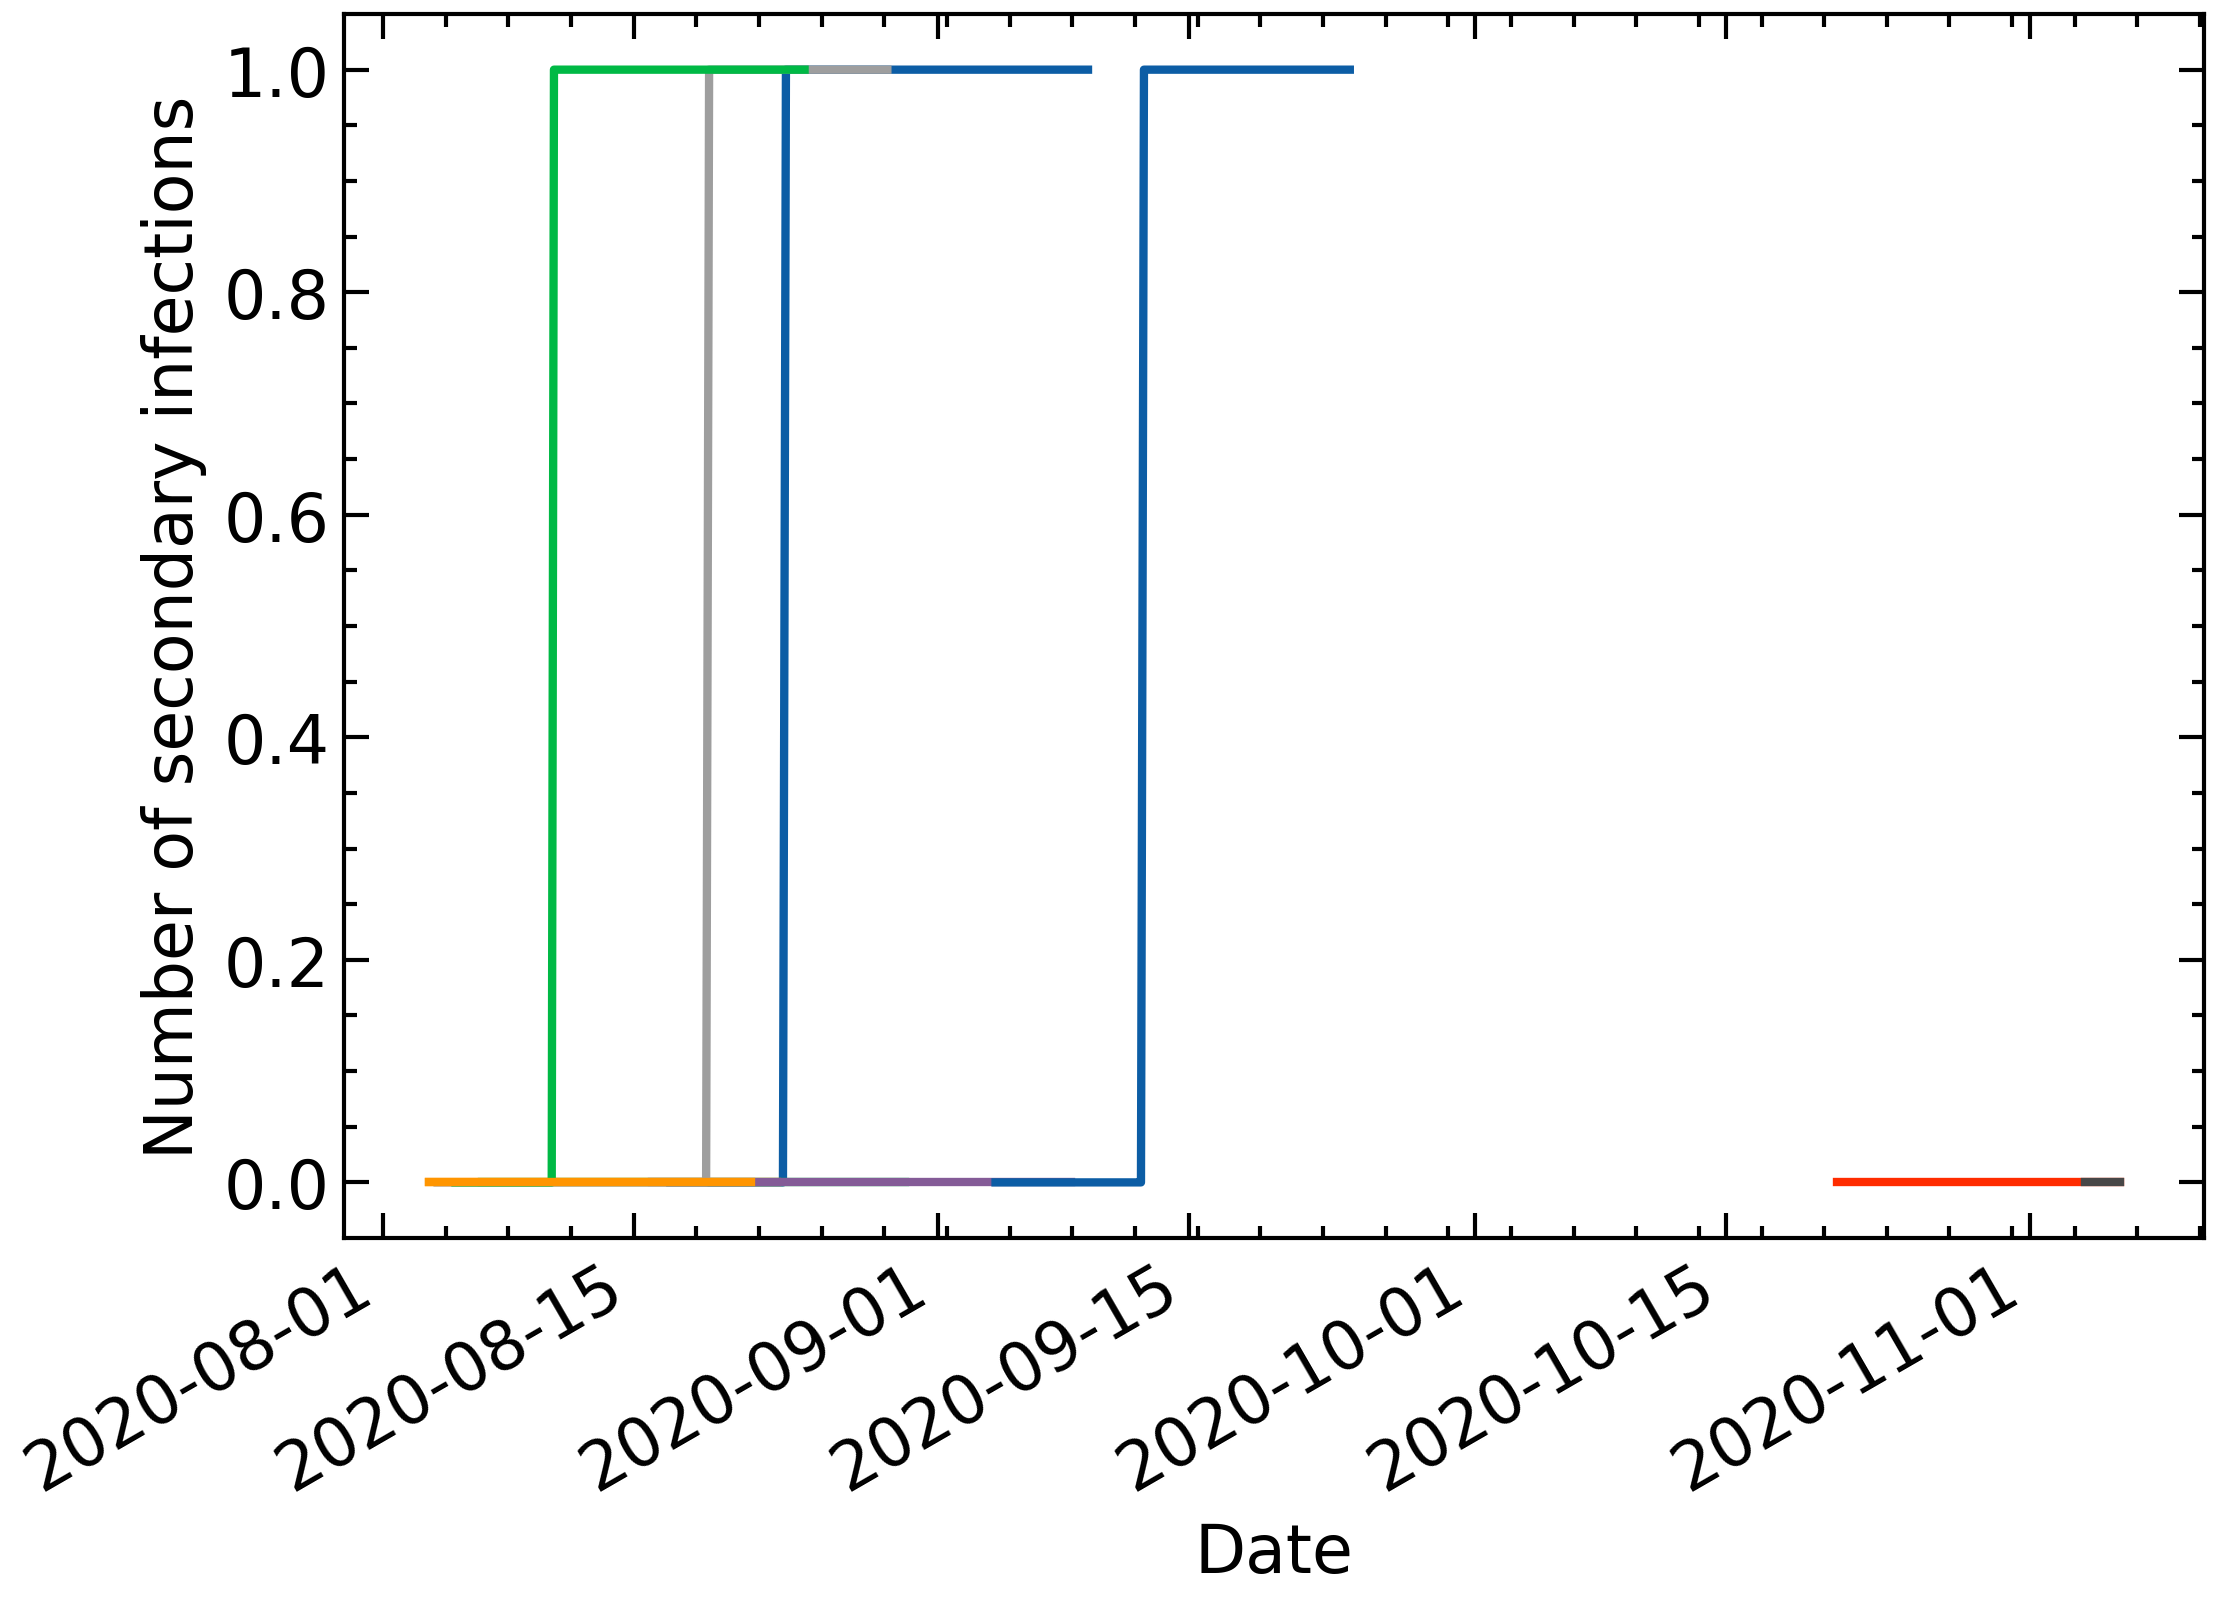

In [61]:
for df_person in random_trajectories:
    df_person['n_secondary_infections'].plot()
plt.ylabel('Number of secondary infections')

plt.xlabel('Date')